Loaded AAPL prices: 2515 days; price column: Close
Loaded AAPL prices: 230 days; price column: Close

Using max expiry as steps = 22 days
Holdout window: 2024-11-27T00:00:00.000000000 to 2024-12-30T00:00:00.000000000 length 22
Training pool size (days): 2493
S_train_paths shape: (12000, 23)

Training hedger for Z=0 (to approximate phi(0)) ...


/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/2248318698.py:1034: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0_for_sim = float(S_train_all[-1])


Epoch 1/120 last_batch_loss = 0.336888
Epoch 10/120 last_batch_loss = 0.015870
Epoch 20/120 last_batch_loss = 0.244384
Epoch 30/120 last_batch_loss = 0.010037
Epoch 40/120 last_batch_loss = 0.013922
Epoch 50/120 last_batch_loss = 0.126174
Epoch 60/120 last_batch_loss = 0.172751
Epoch 70/120 last_batch_loss = 0.183852
Epoch 80/120 last_batch_loss = 0.149643
Epoch 90/120 last_batch_loss = 0.172629
Epoch 100/120 last_batch_loss = 0.167852
Epoch 110/120 last_batch_loss = 0.136434
Epoch 120/120 last_batch_loss = 0.127649
Finished training hedger_zero.

Training hedger for portfolio payoff Z (to approximate phi(Z)) ...
Epoch 1/120 last_batch_loss = 83.859711
Epoch 10/120 last_batch_loss = 74.173615
Epoch 20/120 last_batch_loss = 76.310257
Epoch 30/120 last_batch_loss = 83.704247
Epoch 40/120 last_batch_loss = 78.222313
Epoch 50/120 last_batch_loss = 79.234535
Epoch 60/120 last_batch_loss = 80.887047
Epoch 70/120 last_batch_loss = 92.830574
Epoch 80/120 last_batch_loss = 81.907028
Epoch 90/12

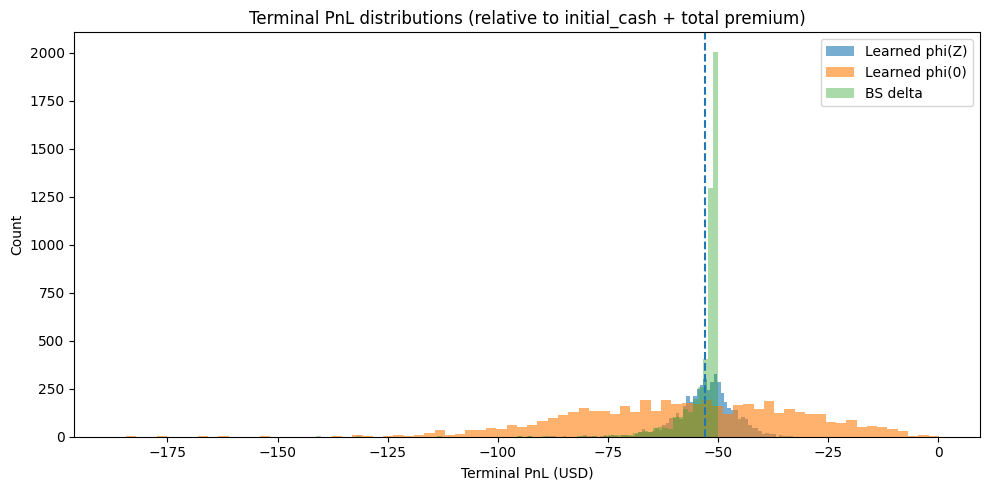

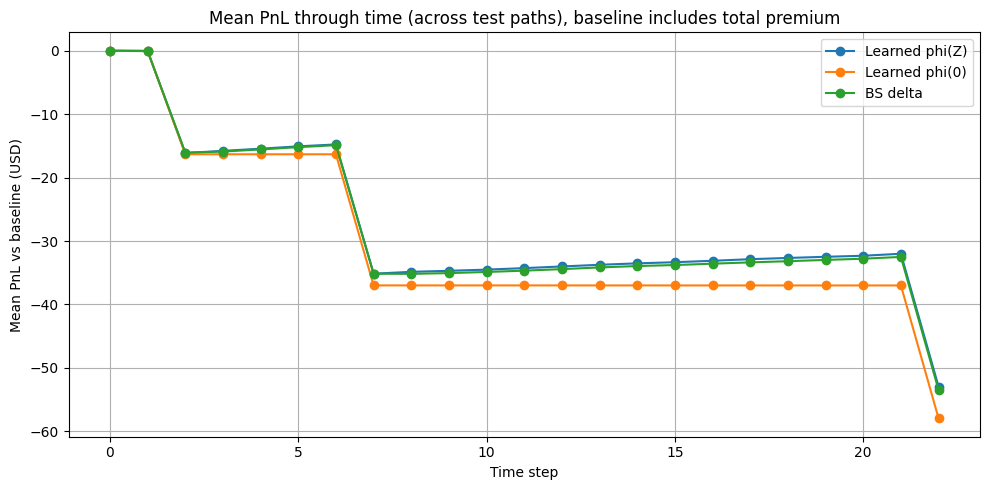

/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/2248318698.py:855: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


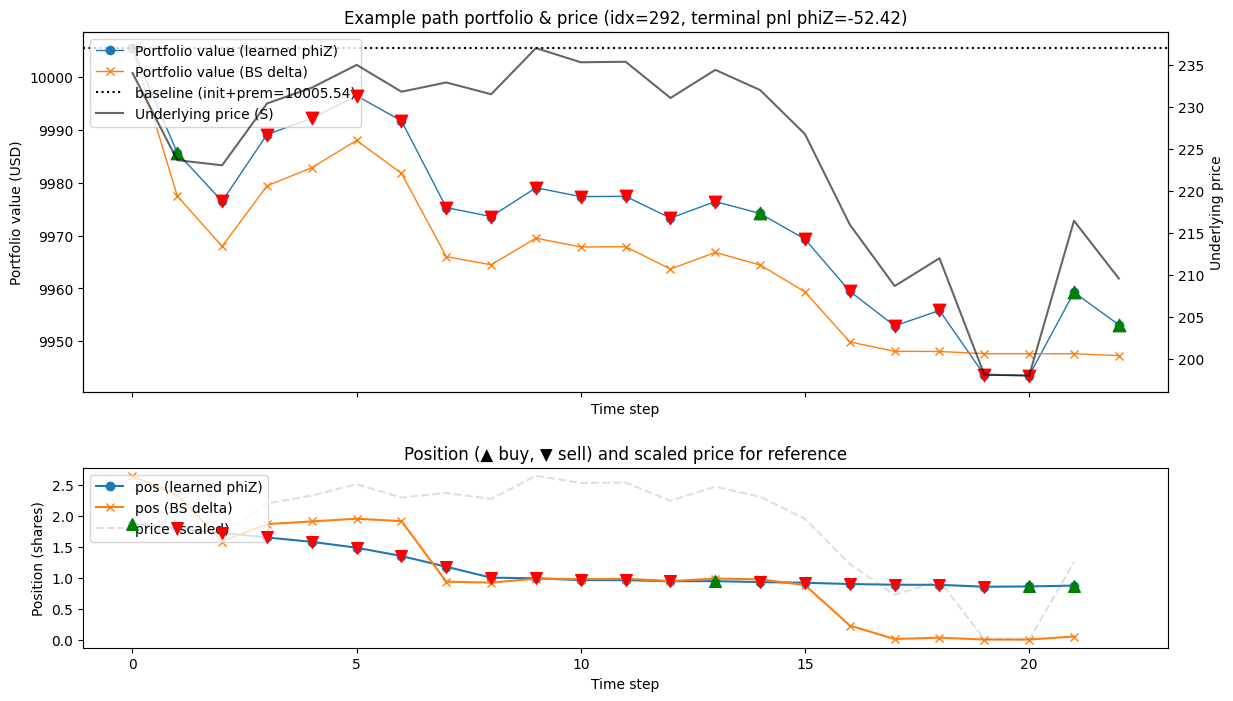

Saved terminal pnl csv: monetary_test_terminal_pnls_portfolio.csv

=== CASH-CENTRIC SUMMARY (baseline = initial_cash + total premium) ===
              mean_final_cash  std_final_cash  median_final_cash  \
learned_phiZ      9952.581055        6.854043        9953.112305   
learned_phi0      9947.582031       25.513588        9948.442383   
bs_delta          9952.050781        6.045614        9954.188477   

              5%_final_cash  95%_final_cash  mean_pnl_vs_baseline  
learned_phiZ    9940.807617     9962.534180            -52.955799  
learned_phi0    9904.947266     9986.925781            -57.954399  
bs_delta        9942.385742     9954.857422            -53.484901  


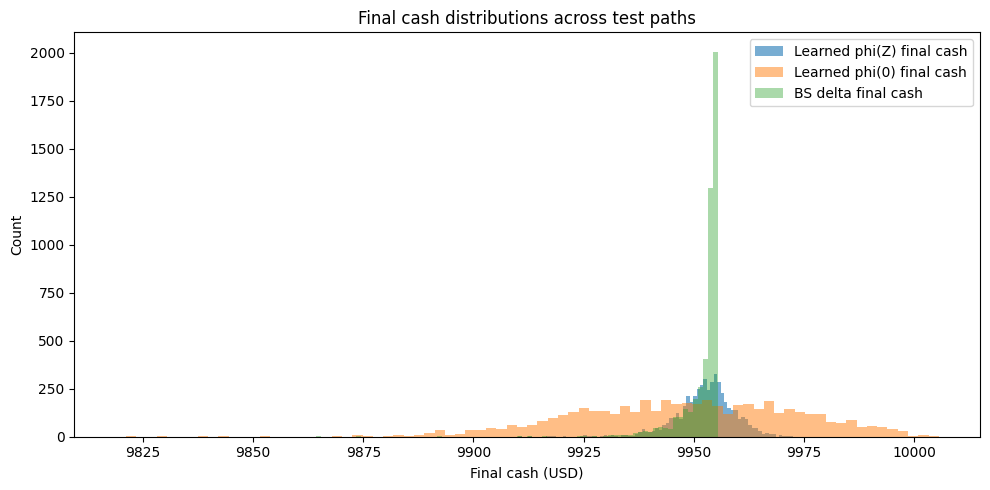

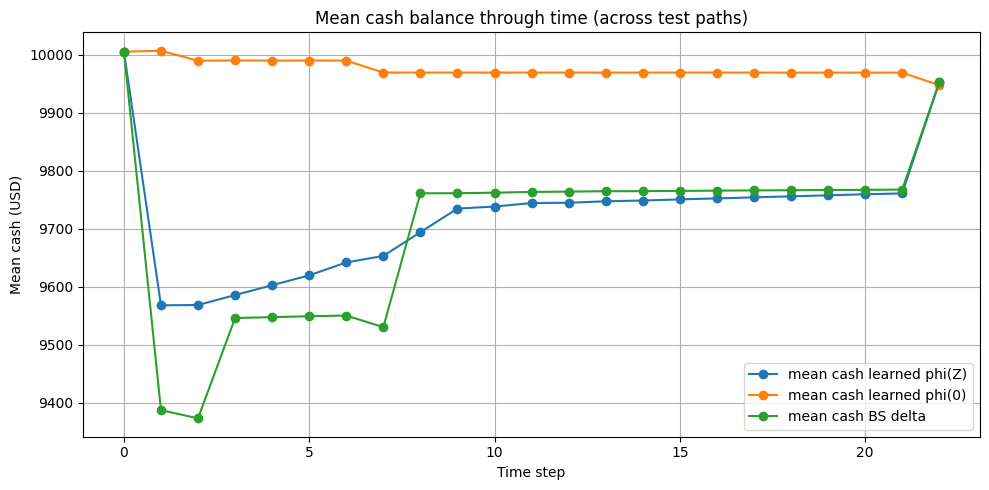

Saved cash_final_summary_portfolio.csv


In [27]:
# deep_hedging_refactor_paper_aligned.py
# Requirements: numpy, pandas, tensorflow, matplotlib, scipy, yfinance
# pip install numpy pandas tensorflow matplotlib scipy yfinance

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import warnings
import logging

# ----------------------------
# Logging / TF noise suppression
# ----------------------------
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

# ----------------------------
# Defaults / Hyperparameters
# ----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DEFAULTS = dict(
    N_TRAIN_PATHS=12000,
    N_TEST_PATHS=5000,
    steps=21,               # will be set to max expiry of portfolio
    batch_size=512,
    epochs=120,
    hid_dim=64,
    learning_rate=3e-4,
    epsilon=0.001,
    alpha_cvar=0.95,
    risk_measure='cvar',    # 'cvar' or 'entropic'
    ent_lambda=1.0,
    op_dim=1,
    r_annual=0.0,
    ann_days=252.0,
)

# ----------------------------
# Market data loader / utils
# ----------------------------
class MarketData:
    def __init__(self, ticker="AAPL", start="2015-01-01", end="2025-12-31", px_col_pref=('Adj Close','Close')):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.px_col_pref = px_col_pref
        self.prices = None
        self.dates = None

    def download(self):
        df = yf.download(self.ticker, start=self.start, end=self.end, progress=False)
        for c in self.px_col_pref:
            if c in df.columns:
                px_col = c
                break
        else:
            raise RuntimeError("No price column found in downloaded data.")
        self.prices = df[px_col].values.astype(np.float32)
        self.dates = df.index.to_numpy()
        print(f"Loaded {self.ticker} prices: {self.prices.shape[0]} days; price column: {px_col}")
        return self.prices, self.dates

    @staticmethod
    def safe_log_returns(series):
        arr = np.asarray(series).ravel()
        if arr.size < 2:
            raise ValueError("Not enough prices to compute returns.")
        return np.diff(np.log(arr)).ravel()

    def build_holdout_and_pool(self, steps):
        if self.prices is None:
            raise RuntimeError("Call download() first.")
        if len(self.prices) < steps + 60:
            raise RuntimeError("Not enough historical data for chosen steps/horizon.")
        holdout_end_idx = len(self.prices) - 1
        holdout_start_idx = holdout_end_idx - steps + 1
        S_holdout = np.asarray(self.prices[holdout_start_idx:holdout_end_idx+1]).ravel()
        dates_holdout = self.dates[holdout_start_idx:holdout_end_idx+1]
        # training pool excludes holdout
        mask = np.ones(len(self.prices), dtype=bool)
        mask[holdout_start_idx:holdout_end_idx+1] = False
        S_train_pool = np.asarray(self.prices[mask]).ravel()
        print("Holdout window:", dates_holdout[0], "to", dates_holdout[-1], "length", len(S_holdout))
        print("Training pool size (days):", len(S_train_pool))
        return S_holdout, dates_holdout, S_train_pool

# ----------------------------
# Bootstrapper
# ----------------------------
class Bootstrapper:
    def __init__(self, returns_pool, seed=SEED):
        self.returns = np.asarray(returns_pool).ravel()
        self.seed = seed
        self.rng = np.random.RandomState(seed)

    def bootstrap_paths_vectorized(self, S0, n_paths, steps, seed=None):
        rng = np.random.RandomState(seed if seed is not None else self.seed)
        returns = self.returns
        n_available = returns.shape[0]
        if n_available < steps:
            raise ValueError(f"Not enough returns ({n_available}) to sample windows of length {steps}.")
        starts = rng.randint(0, n_available - steps + 1, size=n_paths)
        idx_matrix = starts[:, None] + np.arange(steps)[None, :]
        rsegs = returns[idx_matrix]        # (n_paths, steps)
        cums = np.cumsum(rsegs, axis=1)
        zeros = np.zeros((n_paths, 1), dtype=cums.dtype)
        log_prices = np.concatenate([zeros, cums], axis=1)
        paths = S0 * np.exp(log_prices).astype(np.float32)
        return paths

    def extend_paths_by_returns(self, paths, extra_days, seed=None):
        """
        paths: (N, L) numpy array of existing price paths
        returns: extended_paths (N, L + extra_days)
        """
        rng = np.random.RandomState(seed if seed is not None else self.seed)
        N, L = paths.shape
        returns = self.returns
        n_avail = returns.shape[0]
        if n_avail < extra_days:
            raise ValueError("Not enough returns in returns_pool to sample extra_days.")
        starts = rng.randint(0, n_avail - extra_days + 1, size=N)
        idx_matrix = starts[:, None] + np.arange(extra_days)[None, :]
        sampled_rets = returns[idx_matrix]            # (N, extra_days)
        cums = np.cumsum(sampled_rets, axis=1)
        S0 = paths[:, -1][:, None]                    # (N,1)
        multipliers = np.exp(cums).astype(np.float32) # (N, extra_days)
        ext_segment = S0 * multipliers                # (N, extra_days)
        extended = np.concatenate([paths, ext_segment], axis=1)
        return extended

# ----------------------------
# Option specification (fixed K, premium, maturity)
# ----------------------------
class OptionSpec:
    """
    Fixed European option contract on AAPL.
    All parameters are explicitly set (no dynamic strike choosing).
    quantity: number of options you're short (positive = you sold the options).
    premium: premium received per option at t=0.
    expiry_days: maturity in trading days counted from t=0 of your simulated path.
    """
    def __init__(self, name, K, expiry_days, premium, quantity=1.0,
                 option_type='call'):
        self.name = name
        self.K = float(K)
        self.expiry_days = int(expiry_days)
        self.premium = float(premium)
        self.quantity = float(quantity)
        self.option_type = option_type

    def payoff(self, S_terminal):
        S_terminal = np.asarray(S_terminal, dtype=np.float32)
        if self.option_type == 'call':
            return np.maximum(S_terminal - self.K, 0.0).astype(np.float32)
        else:
            return np.maximum(self.K - S_terminal, 0.0).astype(np.float32)

# ----------------------------
# Portfolio payoff helper
# ----------------------------
def portfolio_payoff(paths, option_portfolio):
    """
    paths: (N, L) price paths
    option_portfolio: list[OptionSpec]
    Returns: Z_portfolio (N,) = total short payoff across all options.
    Assumes daily steps, index 'd' approximates 'd days from t=0'.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape
    Z = np.zeros(N, dtype=np.float32)

    for opt in option_portfolio:
        # maturity index within [0, L-1]
        t_idx = min(max(opt.expiry_days, 0), L - 1)
        S_Ti = paths[:, t_idx]
        payoff_i = opt.payoff(S_Ti)          # shape (N,)
        Z += opt.quantity * payoff_i         # short q_i options => total liability

    return Z.astype(np.float32)

# ----------------------------
# Feature builder
# ----------------------------
def build_features(paths):
    N, L = paths.shape
    timesteps = L - 1
    feat = np.zeros((N, L, 2), dtype=np.float32)
    feat[:, :, 0] = np.log(paths)
    tt = np.arange(timesteps, -1, -1) / float(timesteps)  # 1.0 .. 0.0
    feat[:, :, 1] = tt[np.newaxis, :]
    return feat

# ----------------------------
# Hedger network
# ----------------------------
class HedgerNet:
    def __init__(self, input_dim=3, hid_dim=64, op_dim=1, lr=3e-4):
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.op_dim = op_dim
        self.lr = lr
        self.model = self._build_model()
        self.optimizer = optimizers.Adam(learning_rate=self.lr)

    def _build_model(self):
        inp = layers.Input(shape=(self.input_dim,), dtype=tf.float32)
        x = layers.Dense(self.hid_dim, activation="relu")(inp)
        x = layers.Dense(self.hid_dim, activation="relu")(x)
        out = layers.Dense(self.op_dim, activation=None)(x)
        model = Model(inp, out)
        return model

# ----------------------------
# Trainer (TF training with CVaR / entropic objective)
# ----------------------------
class Trainer:
    def __init__(self, hedger: HedgerNet, feat_train, asset_train, Z_train,
                 alpha_cvar=0.95, epsilon=0.0, risk_measure='cvar'):
        self.hedger = hedger
        self.feat_tensor = tf.constant(feat_train)
        self.asset_tensor = tf.constant(asset_train.astype(np.float32))
        self.Zb = tf.constant(Z_train.astype(np.float32))
        self.alpha_cvar = alpha_cvar
        self.epsilon = epsilon
        self.risk_measure = risk_measure
        self.ent_lambda = DEFAULTS['ent_lambda']

    @staticmethod
    @tf.function
    def cvar_tf(terminal_pnl, alpha=0.95):
        loss = -terminal_pnl
        loss_sorted = tf.sort(loss)
        n = tf.shape(loss_sorted)[0]
        idx = tf.cast(tf.math.floor(alpha * tf.cast(n, tf.float32)), tf.int32)
        idx = tf.clip_by_value(idx, 0, n-1)
        var_a = loss_sorted[idx]
        tail = tf.boolean_mask(loss, loss >= var_a)
        return tf.cond(tf.equal(tf.size(tail), 0),
                       lambda: tf.reduce_mean(loss),
                       lambda: tf.reduce_mean(tail))

    @staticmethod
    @tf.function
    def entropic_tf(terminal_pnl, lam=1.0, clip_low=-50.0, clip_high=50.0):
        X = terminal_pnl
        if lam <= 0.0:
            # lam -> 0 limit is just -E[X] (up to constant), but we guard against 0.
            return -tf.reduce_mean(X)

        x = -lam * X
        x = tf.clip_by_value(x, clip_low, clip_high)       # numerical stability
        m = tf.reduce_mean(tf.exp(x))
        return (1.0 / lam) * tf.math.log(m + 1e-30)

    @tf.function
    def forward_train(self, batch_idx):
        Fe = tf.gather(self.feat_tensor, batch_idx)
        Asset = tf.gather(self.asset_tensor, batch_idx)
        Z = tf.gather(self.Zb, batch_idx)
        B = tf.shape(Fe)[0]
        L = tf.shape(Fe)[1]
        prev_pos = tf.zeros((B,1), dtype=tf.float32)
        pnl = tf.zeros((B,), dtype=tf.float32)
        cum_cost = tf.zeros((B,), dtype=tf.float32)
        for t in tf.range(L-1):
            logS = Fe[:, t, 0]
            tt = Fe[:, t, 1]
            inp = tf.stack([logS, tt, tf.reshape(prev_pos, [B])], axis=1)
            new_pos = self.hedger.model(inp)
            S_t = Asset[:, t]
            trade = tf.reshape(new_pos, [B]) - tf.reshape(prev_pos, [B])
            cost = self.epsilon * tf.abs(trade) * S_t
            cum_cost += cost
            dS = Asset[:, t+1] - Asset[:, t]
            pnl += tf.reshape(prev_pos, [B]) * dS
            prev_pos = new_pos
        S_T = Asset[:, -1]
        final_trade = -tf.reshape(prev_pos, [B])
        cum_cost += self.epsilon * tf.abs(final_trade) * S_T
        terminal_pnl = -Z + pnl - cum_cost

        if self.risk_measure == 'entropic':
            loss = Trainer.entropic_tf(terminal_pnl, lam=self.ent_lambda)
        else:
            loss = Trainer.cvar_tf(terminal_pnl, alpha=self.alpha_cvar)
        return loss, terminal_pnl

    def train(self, epochs, batch_size, verbose=True):
        n_train = int(self.asset_tensor.shape[0])
        indices = np.arange(n_train, dtype=np.int32)
        loss_history = []
        for epoch in range(epochs):
            np.random.shuffle(indices)
            last_loss = 0.0
            for start in range(0, n_train, batch_size):
                batch_idx = tf.constant(indices[start:start+batch_size], dtype=tf.int32)
                with tf.GradientTape() as tape:
                    loss_val, _ = self.forward_train(batch_idx)
                grads = tape.gradient(loss_val, self.hedger.model.trainable_variables)
                grads = [g if g is not None else tf.zeros_like(v) for g, v in zip(grads, self.hedger.model.trainable_variables)]
                grads, _ = tf.clip_by_global_norm(grads, 1.0)
                self.hedger.optimizer.apply_gradients(zip(grads, self.hedger.model.trainable_variables))
                last_loss = float(loss_val.numpy())
            loss_history.append(last_loss)
            if verbose and ((epoch+1) % 10 == 0 or epoch == 0):
                print(f"Epoch {epoch+1}/{epochs} last_batch_loss = {last_loss:.6f}")
        return loss_history

# ----------------------------
# Evaluator
# ----------------------------
class Evaluator:
    def __init__(self, hedger_model: Model, epsilon=0.0):
        self.hedger_model = hedger_model
        self.epsilon = epsilon

    def evaluate_policy_with_payoff(self, paths, Z_array, batch_size=512):
        """
        Evaluate hedger_model on given price paths and *custom* payoff samples Z_array.
        Returns: terminal_pnls (N,), hedge_trajs (N, L-1)
        This preserves convention terminal P&L = -Z + pnl - cum_cost
        """
        N, L = paths.shape
        terminal_pnls = np.zeros(N, dtype=np.float32)
        hedge_trajs = np.zeros((N, L-1), dtype=np.float32)
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            B = end - start
            batch_paths = paths[start:end]
            prev_pos = np.zeros(B, dtype=np.float32)
            pnl = np.zeros(B, dtype=np.float32)
            cum_cost = np.zeros(B, dtype=np.float32)
            for t in range(L-1):
                logS = np.log(batch_paths[:, t]).astype(np.float32)
                tt = np.full(B, float((L-1 - t) / (L-1)), dtype=np.float32)
                inp = np.column_stack([logS, tt, prev_pos]).astype(np.float32)
                new_pos = self.hedger_model.predict(inp, batch_size=B, verbose=0).reshape(-1)
                trade = new_pos - prev_pos
                cost = self.epsilon * np.abs(trade) * batch_paths[:, t]
                cum_cost += cost
                dS = batch_paths[:, t+1] - batch_paths[:, t]
                pnl += prev_pos * dS
                prev_pos = new_pos
                hedge_trajs[start:end, t] = prev_pos
            final_trade = -prev_pos
            cum_cost += self.epsilon * np.abs(final_trade) * batch_paths[:, -1]
            terminal_pnls[start:end] = -Z_array[start:end] + pnl - cum_cost
        return terminal_pnls, hedge_trajs

    @staticmethod
    def bs_delta_call(S, K, Ttm, r, sigma):
        if Ttm <= 0 or sigma <= 0:
            return 0.0 if S <= K else 1.0
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * Ttm) / (sigma * np.sqrt(Ttm) + 1e-12)
        return norm.cdf(d1)

# ----------------------------
# Indifference pricer
# ----------------------------
class IndifferencePricer:
    def __init__(self, measure='cvar', ent_lambda=1.0, alpha_cvar=0.95):
        self.measure = measure
        self.ent_lambda = ent_lambda
        self.alpha_cvar = alpha_cvar

    @staticmethod
    def rho_entropic_from_sample(X_samples, lam, clip=(-50,50)):
        x = -lam * X_samples
        x = np.clip(x, clip[0], clip[1])
        m = np.mean(np.exp(x))
        return (1.0/lam) * np.log(m + 1e-30)

    @staticmethod
    def rho_cvar_from_sample(X_samples, alpha):
        losses = -X_samples
        sorted_losses = np.sort(losses)
        N = sorted_losses.shape[0]
        idx = int(np.floor(alpha * float(N)))
        idx = max(0, min(idx, N-1))
        var_a = sorted_losses[idx]
        tail = sorted_losses[sorted_losses >= var_a]
        if tail.size == 0:
            return np.mean(losses)
        return np.mean(tail)

    def estimate_rho_from_sample_np(self, X_samples):
        if self.measure == 'entropic':
            return IndifferencePricer.rho_entropic_from_sample(X_samples, self.ent_lambda)
        elif self.measure == 'cvar':
            return IndifferencePricer.rho_cvar_from_sample(X_samples, self.alpha_cvar)
        else:
            return -np.mean(X_samples)

    def indifference_price(self, term_pnls, Z_test):
        """
        Return (p, rho_X, rho_X_minusZ) with conventional sign:
            term_pnls := X - Z
            Z_test := Z
            rho_X_minusZ = rho(X - Z)
            rho_X = rho(X)
            p = rho_X - rho_X_minusZ
        """
        rho_X_minusZ = self.estimate_rho_from_sample_np(term_pnls)          # rho(X - Z)
        rho_X = self.estimate_rho_from_sample_np(term_pnls + Z_test)        # rho(X)
        p = rho_X - rho_X_minusZ
        return p, rho_X, rho_X_minusZ

    def bootstrap_indifference(self, term_pnls, Z_test, B=500, seed=SEED):
        rng = np.random.RandomState(seed)
        N = term_pnls.shape[0]
        boot_p = np.empty(B, dtype=np.float64)
        for b in range(B):
            idx = rng.randint(0, N, size=N)
            s_term = term_pnls[idx]
            s_Z = Z_test[idx]
            s_pi_minusZ = self.estimate_rho_from_sample_np(s_term)
            s_pi_0 = self.estimate_rho_from_sample_np(s_term + s_Z)
            boot_p[b] = s_pi_0 - s_pi_minusZ
        mean_p = boot_p.mean()
        se = boot_p.std(ddof=1)
        ci_low, ci_high = np.percentile(boot_p, [2.5, 97.5])
        return mean_p, se, (ci_low, ci_high), boot_p

# ----------------------------
# Multi-option portfolio simulator (money, with premiums)
# ----------------------------
def simulate_portfolio_money_on_paths(paths, hedger_model, option_portfolio,
                                      initial_cash=10000.0, epsilon=0.0):
    """
    Simulate selling a fixed portfolio of options on AAPL at t=0 and hedging
    with 'hedger_model'. All options are on the same underlying 'paths'.

    - Each OptionSpec in option_portfolio defines K, expiry_days, premium, quantity.
    - We assume you're SHORT `quantity` options => receive premium, pay payoff.
    - We include all premiums in the starting cash (baseline) exactly like before.

    Returns dict with portfolio_values_time, cash_time, pos_time, trades_time,
    terminal_pnls (relative to initial_cash + total premium), hedge_costs,
    option_payoffs_total, option_payoffs_per_option, premium_total, baseline.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape

    # precompute expiry indices per option
    opt_maturity_idx = {
        opt.name: min(max(opt.expiry_days, 0), L - 1)
        for opt in option_portfolio
    }

    # premiums
    premium_total = float(sum(opt.quantity * opt.premium
                              for opt in option_portfolio))
    initial_cash_arr = np.full(N, float(initial_cash + premium_total),
                               dtype=np.float32)

    portfolio_values_time = np.zeros((N, L), dtype=np.float32)
    cash_time = np.zeros((N, L), dtype=np.float32)
    pos_time = np.zeros((N, L-1), dtype=np.float32)
    trades_time = np.zeros((N, L-1), dtype=np.float32)
    hedge_costs = np.zeros(N, dtype=np.float32)
    option_payoffs_total = np.zeros(N, dtype=np.float32)
    option_payoffs_per_option = {
        opt.name: np.zeros(N, dtype=np.float32) for opt in option_portfolio
    }

    Bsize = 512
    for start in range(0, N, Bsize):
        end = min(start + Bsize, N)
        B = end - start
        batch_paths = paths[start:end]
        cash = initial_cash_arr[start:end].copy()
        prev_pos = np.zeros(B, dtype=np.float32)
        cum_cost = np.zeros(B, dtype=np.float32)

        # t=0 portfolio value
        portfolio_values_time[start:end, 0] = cash + prev_pos * batch_paths[:, 0]
        cash_time[start:end, 0] = cash

        for t in range(L - 1):
            S_t = batch_paths[:, t]
            S_next = batch_paths[:, t + 1]

            # hedging input: (logS, time-to-max-expiry, prev_pos)
            logS = np.log(S_t).astype(np.float32)
            tt = np.full(B, float((L - 1 - t) / (L - 1)), dtype=np.float32)
            inp = np.column_stack([logS, tt, prev_pos]).astype(np.float32)

            new_pos = hedger_model.predict(inp, batch_size=B, verbose=0).reshape(-1)

            trade = new_pos - prev_pos
            cost = epsilon * np.abs(trade) * S_t
            cash -= trade * S_t
            cash -= cost
            cum_cost += cost

            pos_time[start:end, t] = new_pos
            trades_time[start:end, t] = trade

            # mark-to-market portfolio value (before any option expiry cash flows)
            portfolio_values_time[start:end, t+1] = cash + new_pos * S_next
            cash_time[start:end, t+1] = cash

            prev_pos = new_pos

            # --- Handle any option maturities at time index t+1 ---
            for opt in option_portfolio:
                if opt_maturity_idx[opt.name] == (t + 1):
                    payoff = opt.payoff(S_next) * opt.quantity   # (B,)
                    option_payoffs_per_option[opt.name][start:end] += payoff
                    option_payoffs_total[start:end] += payoff
                    cash -= payoff   # we are short => we pay

                    # update cash & portfolio value after paying payoff
                    cash_time[start:end, t+1] = cash
                    portfolio_values_time[start:end, t+1] = cash + prev_pos * S_next

        # final liquidation at time L-1
        ST = batch_paths[:, -1]
        final_trade = -prev_pos
        final_cost = epsilon * np.abs(final_trade) * ST
        cash -= final_trade * ST
        cash -= final_cost
        cum_cost += final_cost

        hedge_costs[start:end] = cum_cost
        portfolio_values_time[start:end, -1] = cash
        cash_time[start:end, -1] = cash

    baseline = float(initial_cash + premium_total)
    terminal_values = portfolio_values_time[:, -1]
    terminal_pnls = terminal_values - baseline

    return {
        'portfolio_values_time': portfolio_values_time,
        'cash_time': cash_time,
        'pos_time': pos_time,
        'trades_time': trades_time,
        'terminal_pnls': terminal_pnls,
        'hedge_costs': hedge_costs,
        'option_payoffs_total': option_payoffs_total,
        'option_payoffs_per_option': option_payoffs_per_option,
        'premium_total': premium_total,
        'baseline': baseline,
    }

# ----------------------------
# BS delta portfolio baseline (same baseline convention)
# ----------------------------
def _run_bs_portfolio_delta_on_paths_with_premium(paths, option_portfolio,
                                                  rv_annual, initial_cash,
                                                  epsilon):
    """
    Black-Scholes delta hedge of the same multi-option portfolio.
    - Uses portfolio delta = sum q_i * delta_i per option.
    - Receives premium_total at t=0, same as simulate_portfolio_money_on_paths.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape

    premium_total = float(sum(opt.quantity * opt.premium
                              for opt in option_portfolio))
    baseline = float(initial_cash + premium_total)
    initial_cash_arr = np.full(N, baseline, dtype=np.float32)

    portfolio_values_time = np.zeros((N, L), dtype=np.float32)
    cash_time = np.zeros((N, L), dtype=np.float32)
    pos_time = np.zeros((N, L-1), dtype=np.float32)
    trades_time = np.zeros((N, L-1), dtype=np.float32)
    hedge_costs = np.zeros(N, dtype=np.float32)
    payoff_arr_total = np.zeros(N, dtype=np.float32)
    payoff_per_option = {
        opt.name: np.zeros(N, dtype=np.float32) for opt in option_portfolio
    }

    # expiry indices
    opt_maturity_idx = {
        opt.name: min(max(opt.expiry_days, 0), L-1) for opt in option_portfolio
    }

    for i in range(N):
        cash = initial_cash_arr[i]
        prev_pos = 0.0
        portfolio_values_time[i,0] = cash
        cash_time[i,0] = cash

        for t in range(L-1):
            S_t = float(paths[i,t])

            # portfolio delta: sum q_i * delta_i
            portfolio_delta = 0.0
            for opt in option_portfolio:
                days_to_maturity = max(opt.expiry_days - t, 0)
                if days_to_maturity <= 0:
                    continue
                Ttm_years = float(days_to_maturity / DEFAULTS['ann_days'])
                delta_i = Evaluator.bs_delta_call(S_t, opt.K, Ttm_years,
                                                  DEFAULTS['r_annual'], rv_annual)
                portfolio_delta += opt.quantity * delta_i

            trade = portfolio_delta - prev_pos
            cost = epsilon * abs(trade) * S_t
            cash -= trade * S_t
            cash -= cost
            hedge_costs[i] += cost

            pos_time[i,t] = portfolio_delta
            trades_time[i,t] = trade
            prev_pos = portfolio_delta

            S_next = float(paths[i,t+1])
            portfolio_values_time[i,t+1] = cash + prev_pos * S_next
            cash_time[i,t+1] = cash

            # handle expiries at t+1
            for opt in option_portfolio:
                if opt_maturity_idx[opt.name] == (t+1):
                    payoff = float(opt.payoff(np.array([S_next]))[0] * opt.quantity)
                    payoff_per_option[opt.name][i] += payoff
                    payoff_arr_total[i] += payoff
                    cash -= payoff
                    cash_time[i,t+1] = cash
                    portfolio_values_time[i,t+1] = cash + prev_pos * S_next

        # final liquidation
        ST = float(paths[i,-1])
        final_trade = -prev_pos
        final_cost = epsilon * abs(final_trade) * ST
        cash -= final_trade * ST
        cash -= final_cost
        hedge_costs[i] += final_cost
        portfolio_values_time[i,-1] = cash
        cash_time[i,-1] = cash

    terminal_values = portfolio_values_time[:,-1]
    terminal_pnls = terminal_values - baseline
    return {
        'portfolio_values_time': portfolio_values_time,
        'cash_time': cash_time,
        'pos_time': pos_time,
        'trades_time': trades_time,
        'terminal_pnls': terminal_pnls,
        'hedge_costs': hedge_costs,
        'option_payoffs_total': payoff_arr_total,
        'option_payoffs_per_option': payoff_per_option,
        'premium_total': premium_total,
        'baseline': baseline,
    }

# ----------------------------
# Terminal PnL summarizer
# ----------------------------
def summarize_terminal_pnls(term_pnls):
    """
    returns pandas Series of summary statistics of money P&L
    terminal_pnls should already be relative to baseline (initial_cash + premium)
    """
    s = pd.Series(term_pnls)
    stats = {
        'count': s.count(),
        'mean': float(s.mean()),
        'std': float(s.std(ddof=1)),
        'min': float(s.min()),
        '5%': float(s.quantile(0.05)),
        'median': float(s.median()),
        '95%': float(s.quantile(0.95)),
        'max': float(s.max()),
        'VaR(95%)': float(-s.quantile(0.05)),   # From loss perspective
        'CVaR(95%)': None
    }
    # CVaR 95% calculation
    q05 = s.quantile(0.05)
    tail = s[s <= q05]
    if len(tail) > 0:
        stats['CVaR(95%)'] = float(-tail.mean())
    else:
        stats['CVaR(95%)'] = float(-s.mean())
    return pd.Series(stats)

# ----------------------------
# Monetary test report (portfolio version)
# ----------------------------
def monetary_test_report(results, initial_cash=10000.0):
    """
    Uses simulate_portfolio_money_on_paths to:
      - simulate and include total premium up-front in cash/portfolio flows
      - print money summary (terminal P&L relative to initial_cash + total premium)
      - plot terminal histograms and mean P&L through time relative to baseline
      - plot example path with buy (▲) and sell (▼) markers
    """
    hedger_Z = results['hedger_Z'].model
    hedger_zero = results['hedger_zero'].model
    S_test_paths = results['S_test_paths']
    Z_test = results['Z_test']
    option_portfolio = results['option_portfolio']
    epsilon = DEFAULTS['epsilon']

    print("\n=== OPTION PORTFOLIO USED ===")
    for opt in option_portfolio:
        print(f"  {opt.name}: K={opt.K:.2f}, T={opt.expiry_days}d, "
              f"qty={opt.quantity}, premium={opt.premium:.2f}")

    # simulate money for both hedgers on the test paths
    sim_Z = simulate_portfolio_money_on_paths(
        S_test_paths, hedger_Z, option_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )
    sim_zero = simulate_portfolio_money_on_paths(
        S_test_paths, hedger_zero, option_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )

    # Black-Scholes delta baseline (portfolio)
    # realized vol from train pool / holdout proxy
    rv_annual = np.std(
        np.diff(np.log(results.get('S_holdout')
                       if results.get('S_holdout') is not None
                       else S_test_paths[:,0]))
    ) * np.sqrt(DEFAULTS['ann_days'])

    sim_bs = _run_bs_portfolio_delta_on_paths_with_premium(
        S_test_paths, option_portfolio, rv_annual,
        initial_cash, epsilon
    )

    premium_total = sim_Z['premium_total']
    print(f"\nTotal premium received for portfolio = {premium_total:.2f}")

    # Summaries (terminal_pnls are relative to baseline = initial_cash + premium_total)
    sum_Z = summarize_terminal_pnls(sim_Z['terminal_pnls'])
    sum_zero = summarize_terminal_pnls(sim_zero['terminal_pnls'])
    sum_bs = summarize_terminal_pnls(sim_bs['terminal_pnls'])

    summary_df = pd.DataFrame({
        'learned_phiZ': sum_Z,
        'learned_phi0': sum_zero,
        'bs_delta': sum_bs
    })

    print("\n=== Monetary Test Summary (terminal PnL vs initial_cash + total premium) ===")
    print(summary_df.T[['mean','std','5%','median','95%','VaR(95%)','CVaR(95%)']])
    print(f"Baseline (initial_cash + total premium) = {initial_cash + premium_total:.2f}")

    # Plot terminal histograms
    plt.figure(figsize=(10,5))
    plt.hist(sim_Z['terminal_pnls'], bins=80, alpha=0.6, label='Learned phi(Z)')
    plt.hist(sim_zero['terminal_pnls'], bins=80, alpha=0.6, label='Learned phi(0)')
    plt.hist(sim_bs['terminal_pnls'], bins=80, alpha=0.4, label='BS delta')
    plt.axvline(summary_df.loc['mean','learned_phiZ'], linestyle='--')
    plt.legend()
    plt.title("Terminal PnL distributions (relative to initial_cash + total premium)")
    plt.xlabel("Terminal PnL (USD)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Plot cumulative mean PnL through time relative to baseline
    baseline = sim_Z['baseline']  # initial_cash + premium_total
    mean_pnl_Z = (sim_Z['portfolio_values_time'] - baseline).mean(axis=0)
    mean_pnl_zero = (sim_zero['portfolio_values_time'] - baseline).mean(axis=0)
    mean_pnl_bs = (sim_bs['portfolio_values_time'] - baseline).mean(axis=0)
    timesteps = np.arange(sim_Z['portfolio_values_time'].shape[1])

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, mean_pnl_Z, '-o', label='Learned phi(Z)')
    plt.plot(timesteps, mean_pnl_zero, '-o', label='Learned phi(0)')
    plt.plot(timesteps, mean_pnl_bs, '-o', label='BS delta')
    plt.xlabel("Time step")
    plt.ylabel("Mean PnL vs baseline (USD)")
    plt.title("Mean PnL through time (across test paths), baseline includes total premium")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Example single path plot WITH underlying price
    idx_med = int(np.argsort(sim_Z['terminal_pnls'])[len(sim_Z['terminal_pnls'])//2])

    pv_phi = sim_Z['portfolio_values_time'][idx_med]   # length L
    pv_bs  = sim_bs['portfolio_values_time'][idx_med]
    pos_phi = sim_Z['pos_time'][idx_med]               # length L-1
    trades_phi = sim_Z['trades_time'][idx_med]
    pos_bs = sim_bs['pos_time'][idx_med]
    trades_bs = sim_bs['trades_time'][idx_med]
    price_path = S_test_paths[idx_med]                 # length L
    L = len(price_path)
    times = np.arange(L)

    fig = plt.figure(figsize=(14,8))
    gs = fig.add_gridspec(2,1, height_ratios=[2,1], hspace=0.28)

    # --- Top: portfolio values + underlying price (twin y axis) ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(times, pv_phi, '-o', label='Portfolio value (learned phiZ)', linewidth=1)
    ax0.plot(times, pv_bs,  '-x', label='Portfolio value (BS delta)', linewidth=1)
    ax0.axhline(baseline, color='k', linestyle=':', label=f'baseline (init+prem={baseline:.2f})')

    for t in range(L-1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            m_x = t+1
            m_y = pv_phi[m_x]
            if tr > 0:
                ax0.scatter(m_x, m_y, marker='^', color='green', s=80, zorder=6, label='_nolegend_')  # buy
            else:
                ax0.scatter(m_x, m_y, marker='v', color='red', s=80, zorder=6, label='_nolegend_')    # sell

    axp = ax0.twinx()
    axp.plot(times, price_path, '-k', alpha=0.6, label='Underlying price (S)')
    axp.set_ylabel('Underlying price', color='k')
    axp.tick_params(axis='y', labelcolor='k')

    ax0.set_ylabel('Portfolio value (USD)')
    ax0.set_title(f"Example path portfolio & price (idx={idx_med}, terminal pnl phiZ={sim_Z['terminal_pnls'][idx_med]:.2f})")
    ax0.set_xlabel('Time step')

    handles0, labels0 = ax0.get_legend_handles_labels()
    handles1, labels1 = axp.get_legend_handles_labels()
    ax0.legend(handles0 + handles1, labels0 + labels1, loc='upper left')

    # --- Bottom: positions + trade markers, with scaled price ---
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    times_pos = np.arange(L-1)
    ax1.plot(times_pos, pos_phi, '-o', label='pos (learned phiZ)')
    ax1.plot(times_pos, pos_bs,  '-x', label='pos (BS delta)')

    p_min, p_max = price_path.min(), price_path.max()
    pos_ymin, pos_ymax = np.min([pos_phi.min(), pos_bs.min()]), np.max([pos_phi.max(), pos_bs.max()])
    if (p_max - p_min) > 1e-12 and (pos_ymax - pos_ymin) > 1e-12:
        price_scaled = (price_path[:-1] - p_min) / (p_max - p_min + 1e-12) * (pos_ymax - pos_ymin) + pos_ymin
        ax1.plot(times_pos, price_scaled, '--', color='gray', alpha=0.25, label='price (scaled)')

    for t in range(L-1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            if tr > 0:
                ax1.scatter(t, pos_phi[t], marker='^', color='green', s=70, zorder=6, label='_nolegend_')
            else:
                ax1.scatter(t, pos_phi[t], marker='v', color='red', s=70, zorder=6, label='_nolegend_')

    ax1.set_ylabel('Position (shares)')
    ax1.set_xlabel('Time step')
    ax1.set_title('Position (▲ buy, ▼ sell) and scaled price for reference')
    ax1.legend(loc='upper left')

    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.show()

    # Save terminal csv including baseline and total premium
    out = pd.DataFrame({
        'phiZ_terminal_pnl_vs_baseline': sim_Z['terminal_pnls'],
        'phi0_terminal_pnl_vs_baseline': sim_zero['terminal_pnls'],
        'bs_terminal_pnl_vs_baseline': sim_bs['terminal_pnls'],
        'Z_test': Z_test
    })
    out['baseline'] = baseline
    out['premium_total'] = premium_total
    out.to_csv("monetary_test_terminal_pnls_portfolio.csv", index=False)
    print("Saved terminal pnl csv: monetary_test_terminal_pnls_portfolio.csv")

    return {
        'sim_Z': sim_Z,
        'sim_zero': sim_zero,
        'sim_bs': sim_bs,
        'summary_df': summary_df,
        'premium_total': premium_total,
        'option_portfolio': option_portfolio,
        'Z_test': Z_test,
        'baseline': baseline
    }

# ----------------------------
# Cash-focused reporting
# ----------------------------
def summarize_cash_endpoints(simulation_dict):
    """
    Return a pandas Series summary of final cash values across paths.
    simulation_dict should include 'cash_time' (N,L).
    Baseline is whatever was passed as initial_cash+premium when sim was run.
    """
    cash_time = simulation_dict['cash_time']  # (N,L)
    final_cash = cash_time[:, -1]             # money in bank at final time
    pnl_vs_baseline = final_cash - simulation_dict['baseline']

    stats = pd.Series({
        'count': len(final_cash),
        'mean_final_cash': float(final_cash.mean()),
        'std_final_cash': float(final_cash.std(ddof=1)),
        'median_final_cash': float(np.median(final_cash)),
        '5%_final_cash': float(np.quantile(final_cash, 0.05)),
        '95%_final_cash': float(np.quantile(final_cash, 0.95)),
        'mean_pnl_vs_baseline': float(pnl_vs_baseline.mean()),
        'std_pnl_vs_baseline': float(pnl_vs_baseline.std(ddof=1)),
        'VaR(95%)_cash_loss': float(-np.quantile(pnl_vs_baseline, 0.05)),
    })
    return stats, final_cash, pnl_vs_baseline

def monetary_cash_report(money_results, initial_cash=10000.0):
    """
    Cash-centric report.
    - Takes the output of monetary_test_report.
    - Computes final cash distributions and plots cash-through-time.
    """
    sim_Z = money_results['sim_Z']
    sim_zero = money_results['sim_zero']
    sim_bs = money_results['sim_bs']
    Z_test = money_results['Z_test']

    stats_Z, final_cash_Z, pnl_vs_base_Z = summarize_cash_endpoints(sim_Z)
    stats_zero, final_cash_zero, pnl_vs_base_zero = summarize_cash_endpoints(sim_zero)
    stats_bs, final_cash_bs, pnl_vs_base_bs = summarize_cash_endpoints(sim_bs)

    df_stats = pd.DataFrame({
        'learned_phiZ_final_cash': stats_Z,
        'learned_phi0_final_cash': stats_zero,
        'bs_delta_final_cash': stats_bs
    })

    print("\n=== CASH-CENTRIC SUMMARY (baseline = initial_cash + total premium) ===")
    show_df = pd.DataFrame({
        'learned_phiZ': [
            stats_Z['mean_final_cash'],
            stats_Z['std_final_cash'],
            stats_Z['median_final_cash'],
            stats_Z['5%_final_cash'],
            stats_Z['95%_final_cash'],
            stats_Z['mean_pnl_vs_baseline'],
        ],
        'learned_phi0': [
            stats_zero['mean_final_cash'],
            stats_zero['std_final_cash'],
            stats_zero['median_final_cash'],
            stats_zero['5%_final_cash'],
            stats_zero['95%_final_cash'],
            stats_zero['mean_pnl_vs_baseline'],
        ],
        'bs_delta': [
            stats_bs['mean_final_cash'],
            stats_bs['std_final_cash'],
            stats_bs['median_final_cash'],
            stats_bs['5%_final_cash'],
            stats_bs['95%_final_cash'],
            stats_bs['mean_pnl_vs_baseline'],
        ],
    }, index=['mean_final_cash','std_final_cash','median_final_cash',
              '5%_final_cash','95%_final_cash','mean_pnl_vs_baseline'])
    print(show_df.T)

    # Plot histograms of final cash
    plt.figure(figsize=(10,5))
    plt.hist(final_cash_Z, bins=80, alpha=0.6, label='Learned phi(Z) final cash')
    plt.hist(final_cash_zero, bins=80, alpha=0.5, label='Learned phi(0) final cash')
    plt.hist(final_cash_bs, bins=80, alpha=0.4, label='BS delta final cash')
    plt.xlabel("Final cash (USD)")
    plt.ylabel("Count")
    plt.title("Final cash distributions across test paths")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mean cash through time plot (cash only)
    mean_cash_Z = sim_Z['cash_time'].mean(axis=0)
    mean_cash_zero = sim_zero['cash_time'].mean(axis=0)
    mean_cash_bs = sim_bs['cash_time'].mean(axis=0)
    timesteps = np.arange(sim_Z['cash_time'].shape[1])

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, mean_cash_Z, '-o', label='mean cash learned phi(Z)')
    plt.plot(timesteps, mean_cash_zero, '-o', label='mean cash learned phi(0)')
    plt.plot(timesteps, mean_cash_bs, '-o', label='mean cash BS delta')
    plt.xlabel("Time step")
    plt.ylabel("Mean cash (USD)")
    plt.title("Mean cash balance through time (across test paths)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save CSVs: final cash
    out_df = pd.DataFrame({
        'final_cash_phiZ': final_cash_Z,
        'final_cash_phi0': final_cash_zero,
        'final_cash_bs': final_cash_bs,
        'Z_test': Z_test
    })
    out_df.to_csv("cash_final_summary_portfolio.csv", index=False)
    print("Saved cash_final_summary_portfolio.csv")

    return {
        'stats_df': df_stats,
        'final_cash_arrays': {
            'phiZ': final_cash_Z,
            'phi0': final_cash_zero,
            'bs': final_cash_bs
        },
        'pnl_vs_baseline_arrays': {
            'phiZ': pnl_vs_base_Z,
            'phi0': pnl_vs_base_zero,
            'bs': pnl_vs_base_bs
        },
        'mean_cash_time': {
            'phiZ': mean_cash_Z,
            'phi0': mean_cash_zero,
            'bs': mean_cash_bs
        },
        'csv_saved': "cash_final_summary_portfolio.csv"
    }

# ----------------------------
# Full pipeline (paper-aligned, multi-option portfolio)
# ----------------------------
def run_full_pipeline_paper_aligned():
    cfg = DEFAULTS.copy()
    cfg['epochs'] = 120  # you can tweak

    # 1) TRAIN / TEST SPLIT
    md_train = MarketData("AAPL", "2015-01-01", "2024-12-31")
    S_train_all, dates_train_all = md_train.download()

    md_test = MarketData("AAPL", "2025-01-01", "2025-12-31")
    S_test_all, dates_test_all = md_test.download()

    # 2) Define portfolio FIRST so we know max expiry / steps
    # Use last available TRAIN price as S0 proxy
    S0_for_sim = float(S_train_all[-1])

    option_portfolio = [
        # 21-day ATM call, short 1
        OptionSpec(
            name="C21_ATM",
            K=220.0,
            expiry_days=22,
            premium=3.25,
            quantity=1.0,
            option_type='call'
        ),

        # 21-day 5% OTM call, short 1
        OptionSpec(
            name="C21_OTM_5pct",
            K=215.0,
            expiry_days=7,
            premium=1.41,
            quantity=1.0,
            option_type='call'
        ),

        # 5-day ATM weekly call, short 0.73
        OptionSpec(
            name="C5_ATM_weekly",
            K=212.0,
            expiry_days=2,
            premium=1.20,
            quantity=0.73,
            option_type='call'
        ),
    ]

    max_expiry = max(opt.expiry_days for opt in option_portfolio)
    cfg['steps'] = max_expiry  # horizon in days
    print(f"\nUsing max expiry as steps = {cfg['steps']} days")

    # ==========================================================
    # 3) HOLDOUT + POOL FROM *TRAIN DATA ONLY*
    # ==========================================================
    # md_train already has prices from 2015–2024
    S_holdout, dates_holdout, S_train_pool = md_train.build_holdout_and_pool(cfg['steps'])

    # 4) compute returns for bootstrap (from training pool only)
    returns_train = MarketData.safe_log_returns(S_train_pool)
    # fallback no longer needs S_all; just use S_train_all if ever needed
    if len(returns_train) >= cfg['steps']:
        returns_for_bootstrap = returns_train
    else:
        returns_for_bootstrap = MarketData.safe_log_returns(S_train_all)

    # 5) Bootstrapper
    S0_for_sim = float(S_train_pool[-1]) if len(S_train_pool) > 0 else float(S_train_all[-1])
    boot = Bootstrapper(returns_for_bootstrap, seed=SEED)
    S_train_paths = boot.bootstrap_paths_vectorized(S0_for_sim,
                                                    cfg['N_TRAIN_PATHS'],
                                                    cfg['steps'],
                                                    seed=SEED)
    print("S_train_paths shape:", S_train_paths.shape)

    # Ensure paths are at least as long as max_expiry (defensive; here max_expiry == cfg['steps'])
    current_horizon = S_train_paths.shape[1] - 1
    if current_horizon < max_expiry:
        extra = max_expiry - current_horizon
        S_train_paths = boot.extend_paths_by_returns(S_train_paths, extra, seed=SEED+10)

    feat_train = build_features(S_train_paths)

    # 6) Payoffs for training: portfolio payoff (short options portfolio)
    Z_train = portfolio_payoff(S_train_paths, option_portfolio)

    # 7) Train hedger for Z = 0  (phi(0))
    Z_zero_train = np.zeros_like(Z_train)
    hedger_zero = HedgerNet(input_dim=feat_train.shape[-1] + 1,
                            hid_dim=cfg['hid_dim'],
                            op_dim=cfg['op_dim'],
                            lr=cfg['learning_rate'])
    hedger_zero.optimizer = optimizers.Adam(learning_rate=cfg['learning_rate'])
    trainer_zero = Trainer(hedger_zero, feat_train, S_train_paths, Z_zero_train,
                           alpha_cvar=cfg['alpha_cvar'],
                           epsilon=cfg['epsilon'],
                           risk_measure=cfg['risk_measure'])
    print("\nTraining hedger for Z=0 (to approximate phi(0)) ...")
    loss_hist_zero = trainer_zero.train(epochs=cfg['epochs'],
                                        batch_size=cfg['batch_size'],
                                        verbose=True)
    print("Finished training hedger_zero.")

    # 8) Train hedger for actual portfolio payoff Z (phi(Z))
    hedger_Z = HedgerNet(input_dim=feat_train.shape[-1] + 1,
                         hid_dim=cfg['hid_dim'],
                         op_dim=cfg['op_dim'],
                         lr=cfg['learning_rate'])
    hedger_Z.optimizer = optimizers.Adam(learning_rate=cfg['learning_rate'])
    trainer_Z = Trainer(hedger_Z, feat_train, S_train_paths, Z_train,
                        alpha_cvar=cfg['alpha_cvar'],
                        epsilon=cfg['epsilon'],
                        risk_measure=cfg['risk_measure'])
    print("\nTraining hedger for portfolio payoff Z (to approximate phi(Z)) ...")
    loss_hist_Z = trainer_Z.train(epochs=cfg['epochs'],
                                  batch_size=cfg['batch_size'],
                                  verbose=True)
    print("Finished training hedger_Z.")

    # 9) Build *simulated* test paths (still from train distribution)
    S_test_paths = boot.bootstrap_paths_vectorized(S0_for_sim,
                                                   cfg['N_TEST_PATHS'],
                                                   cfg['steps'],
                                                   seed=SEED+1)
    current_horizon_test = S_test_paths.shape[1] - 1
    if current_horizon_test < max_expiry:
        extra_test = max_expiry - current_horizon_test
        S_test_paths = boot.extend_paths_by_returns(S_test_paths,
                                                    extra_test,
                                                    seed=SEED+11)
    Z_test = portfolio_payoff(S_test_paths, option_portfolio)

    # 10) Evaluate both hedgers on same simulated test paths
    ev_zero = Evaluator(hedger_zero.model, epsilon=cfg['epsilon'])
    ev_Z = Evaluator(hedger_Z.model, epsilon=cfg['epsilon'])

    term_pnls_zero, hedge_trajs_zero = ev_zero.evaluate_policy_with_payoff(
        S_test_paths, np.zeros_like(Z_test), batch_size=cfg['batch_size']
    )
    term_pnls_Z, hedge_trajs_Z = ev_Z.evaluate_policy_with_payoff(
        S_test_paths, Z_test, batch_size=cfg['batch_size']
    )

    # 11) Indifference price using pricer (phi(Z) - phi(0))
    pricer = IndifferencePricer(measure=cfg['risk_measure'],
                                ent_lambda=cfg['ent_lambda'],
                                alpha_cvar=cfg['alpha_cvar'])
    phi0 = pricer.estimate_rho_from_sample_np(term_pnls_zero)
    phiZ = pricer.estimate_rho_from_sample_np(term_pnls_Z)
    pZ = phiZ - phi0

    mean_p, se_p, ci_p, bsamps = pricer.bootstrap_indifference(
        term_pnls_Z, Z_test, B=500, seed=SEED
    )

    # 12) Single holdout diagnostics (from TRAIN data, 2015–2024)
    S_holdout_paths = S_holdout.reshape(1, -1)
    Z_holdout = portfolio_payoff(S_holdout_paths, option_portfolio)
    ev_holdout = Evaluator(hedger_Z.model, epsilon=cfg['epsilon'])
    term_pnls_holdout, hedge_traj_holdout = ev_holdout.evaluate_policy_with_payoff(
        S_holdout_paths, Z_holdout, batch_size=1
    )
    term_pnl_holdout = float(term_pnls_holdout[0])
    term_pnl_bs_holdout = float('nan')  # not implemented for portfolio here

    # 13) Print summary (paper-aligned style)
    print("\n=== PAPER-ALIGNED SUMMARY (portfolio) ===")
    print(f"phi(0) (approx) = {float(phi0):.6f}")
    print(f"phi(Z) (approx) = {float(phiZ):.6f}")
    print(f"indifference price p(Z) = phi(Z) - phi(0) = {float(pZ):.6f}")
    print(f"Bootstrap mean p(Z) = {mean_p:.6f}, SE = {se_p:.6f}, 95% CI = {ci_p}")
    print(f"Learned policy (phi(Z) hedger): mean terminal pnl on test set = {term_pnls_Z.mean():.6f}, std = {term_pnls_Z.std():.6f}")
    print(f"Learned hedger single-holdout pnl (portfolio) = {term_pnl_holdout:.6f}")
    print("BS holdout pnl for multi-option portfolio not implemented in this script.")

    # Save a short summary file
    with open("deep_hedging_phi_summary_portfolio.txt", "w") as f:
        f.write("PAPER-ALIGNED DEEP HEDGING SUMMARY (PORTFOLIO)\n")
        f.write(f"phi(0) = {float(phi0):.12f}\n")
        f.write(f"phi(Z) = {float(phiZ):.12f}\n")
        f.write(f"p(Z) = {float(pZ):.12f}\n")
        f.write(f"bootstrap_mean = {mean_p:.12f}, se = {se_p:.12f}, "
                f"ci = ({ci_p[0]:.12f}, {ci_p[1]:.12f})\n")
    print("Saved paper-aligned summary to deep_hedging_phi_summary_portfolio.txt")

    print(dates_holdout)

    return {
        'hedger_zero': hedger_zero,
        'hedger_Z': hedger_Z,
        'trainer_loss_history_zero': loss_hist_zero,
        'trainer_loss_history_Z': loss_hist_Z,
        'term_pnls_tests_zero': term_pnls_zero,
        'term_pnls_tests_Z': term_pnls_Z,
        'Z_test': Z_test,
        'phi': (phi0, phiZ, pZ),
        'holdout': (term_pnl_holdout, term_pnl_bs_holdout),
        'S_holdout': S_holdout,
        'dates_holdout': dates_holdout,
        'hedge_trajs_zero': hedge_trajs_zero,
        'hedge_trajs_Z': hedge_trajs_Z,
        'S_test_paths': S_test_paths,
        'bsamps': bsamps,
        'mean_p': mean_p,
        'ci_p': ci_p,
        'se_p': se_p,
        'hedge_traj_holdout': hedge_traj_holdout,
        'option_portfolio': option_portfolio,
        # NEW: raw train/test series for real-options evaluation
        'S_train_all': S_train_all,
        'dates_train_all': dates_train_all,
        'S_test_all': S_test_all,
        'dates_test_all': dates_test_all,
    }


# ----------------------------
# Run the paper-aligned pipeline if script is executed
# ----------------------------
if __name__ == "__main__":
    results = run_full_pipeline_paper_aligned()
    money_results = monetary_test_report(results, initial_cash=10000.0)
    cash_results = monetary_cash_report(money_results, initial_cash=10000.0)



=== Tail risk diagnostics setup ===
Total premium received (portfolio) = 5.5360
Baseline used for PnLs = initial_cash + total_premium = 10005.5360

=== Tail risk diagnostics (P&L vs baseline, alpha=0.95) ===
              mean_PnL    std_PnL  VaR_PnL_95  CVaR_PnL_95
naked_short -57.590363  25.416164 -100.094772  -113.957283
hedged_phiZ -52.685539   7.358237  -65.229492   -71.285751
phi0_only   -57.584618  25.391880 -100.038086  -113.894073
bs_delta    -53.157837   6.027387  -62.801758   -71.800064

--- Comparison: hedged_phiZ vs naked_short (P&L units) ---
Naked:  VaR = -100.0948,  CVaR = -113.9573
Hedged: VaR = -65.2295, CVaR = -71.2858
✅ Hedger reduces tail losses: PnL in the worst α% scenarios is less negative.


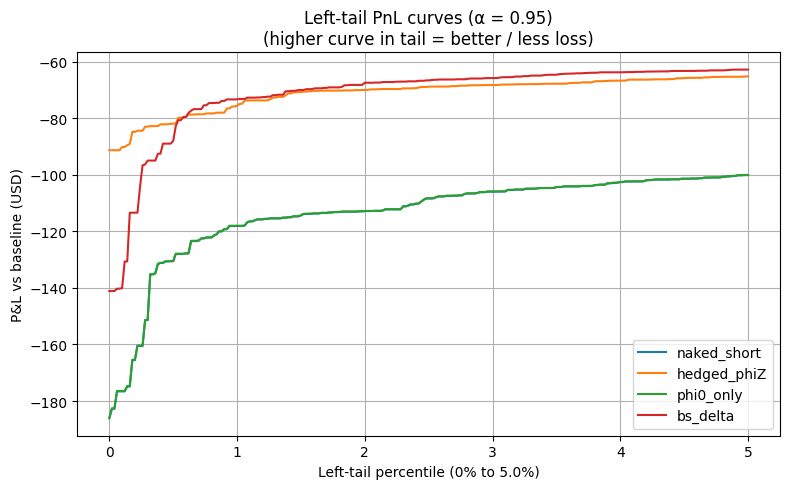

In [ ]:
def tail_risk_diagnostics(results, money_results, alpha=0.95):
    """
    Compare tail risk of:
      - naked short portfolio (no hedging, only premium vs payoff)
      - learned phi(Z) hedger (sim_Z)
      - learned phi(0) hedger (sim_zero)
      - BS delta hedge (sim_bs)

    Uses terminal PnLs from monetary_test_report (already relative to
    baseline = initial_cash + total_premium) and constructs naked PnL
    vs the *same baseline*.

    Baseline convention:
      - All hedged strategies: PnL = terminal_value - (initial_cash + total_premium)
      - Naked: start with same baseline, pay total portfolio payoff Z,
        so final wealth = baseline - Z, hence PnL_vs_baseline = -Z.

    alpha: e.g. 0.95 -> look at worst 5% of PnL distribution.
    """

    # 1) Pull what we need
    Z_test = np.asarray(results['Z_test'], dtype=np.float32)
    premium_total = float(money_results.get('premium_total', 0.0))
    baseline = float(money_results.get('baseline', 0.0))

    print("\n=== Tail risk diagnostics setup ===")
    print(f"Total premium received (portfolio) = {premium_total:.4f}")
    print(f"Baseline used for PnLs = initial_cash + total_premium = {baseline:.4f}")

    # Naked short PnL relative to the SAME baseline (initial_cash + total_premium):
    # Start with baseline, do not hedge, only pay Z:
    #   final_wealth = baseline - Z
    #   => PnL_vs_baseline = final_wealth - baseline = -Z
    naked_pnls = -Z_test

    sim_Z    = money_results['sim_Z']
    sim_zero = money_results['sim_zero']
    sim_bs   = money_results['sim_bs']

    hedged_pnls = np.asarray(sim_Z['terminal_pnls'], dtype=np.float32)
    phi0_pnls   = np.asarray(sim_zero['terminal_pnls'], dtype=np.float32)
    bs_pnls     = np.asarray(sim_bs['terminal_pnls'], dtype=np.float32)

    # 2) Tail stats helper (works in PnL space: more negative = worse)
    def tail_stats(pnls, alpha):
        pnls = np.sort(np.asarray(pnls))   # ascending: worst first
        N = pnls.shape[0]
        tail_frac = 1.0 - alpha
        tail_count = max(int(np.floor(tail_frac * N)), 1)
        tail_slice = pnls[:tail_count]
        var_pnl = pnls[tail_count - 1]         # PnL at tail boundary (VaR in PnL units)
        cvar_pnl = float(tail_slice.mean())    # mean PnL in worst tail
        return var_pnl, cvar_pnl

    # 3) Compute stats for all strategies
    all_pnls = {
        "naked_short": naked_pnls,
        "hedged_phiZ": hedged_pnls,
        "phi0_only":   phi0_pnls,
        "bs_delta":    bs_pnls,
    }

    rows = {}
    for name, arr in all_pnls.items():
        arr = np.asarray(arr, dtype=np.float32)
        var_pnl, cvar_pnl = tail_stats(arr, alpha)
        rows[name] = {
            "mean_PnL": float(arr.mean()),
            "std_PnL": float(arr.std(ddof=1)),
            f"VaR_PnL_{int(alpha*100)}": float(var_pnl),
            f"CVaR_PnL_{int(alpha*100)}": float(cvar_pnl),
        }

    df = pd.DataFrame(rows).T

    print(f"\n=== Tail risk diagnostics (P&L vs baseline, alpha={alpha}) ===")
    print(df)

    # Quick textual verdict comparing naked vs hedged_phiZ
    var_naked   = df.loc["naked_short", f"VaR_PnL_{int(alpha*100)}"]
    cvar_naked  = df.loc["naked_short", f"CVaR_PnL_{int(alpha*100)}"]
    var_hedged  = df.loc["hedged_phiZ", f"VaR_PnL_{int(alpha*100)}"]
    cvar_hedged = df.loc["hedged_phiZ", f"CVaR_PnL_{int(alpha*100)}"]

    print("\n--- Comparison: hedged_phiZ vs naked_short (P&L units) ---")
    print(f"Naked:  VaR = {var_naked:.4f},  CVaR = {cvar_naked:.4f}")
    print(f"Hedged: VaR = {var_hedged:.4f}, CVaR = {cvar_hedged:.4f}")

    if var_hedged > var_naked and cvar_hedged > cvar_naked:
        print("✅ Hedger reduces tail losses: PnL in the worst α% scenarios is less negative.")
    else:
        print("⚠️ Hedger does not clearly dominate naked short in the left tail (or only partially).")

    # 4) Plot: left-tail PnL curves (sorted PnL vs tail percentile)
    plt.figure(figsize=(8,5))
    for name, arr in all_pnls.items():
        arr = np.sort(np.asarray(arr))
        N = len(arr)
        probs = np.linspace(0.0, 1.0, N, endpoint=False)  # 0 .. ~1
        tail_mask = probs <= (1.0 - alpha)                # e.g. 0–5%
        plt.plot(
            probs[tail_mask] * 100.0,    # percentile in %
            arr[tail_mask],              # PnL values
            label=name
        )
    plt.xlabel(f"Left-tail percentile (0% to {(1.0 - alpha)*100:.1f}%)")
    plt.ylabel("P&L vs baseline (USD)")
    plt.title(f"Left-tail PnL curves (α = {alpha})\n(higher curve in tail = better / less loss)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


tail_df = tail_risk_diagnostics(results, money_results, alpha=0.95)

In [24]:
options_df = pd.read_pickle("/Users/anuradharau/Capstone Project Quant Finance Diffusion/mydf.pkl")

In [25]:
options_df

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,AAPL250718C00090000,AAPL,2025-07-18,90.00,call,120.00,120.28,119.80,176,120.75,15,12,405,2025-07-16,4.62452,0.99597,0.00017,-0.22525,0.00186,0.00488
1,AAPL250718P00090000,AAPL,2025-07-18,90.00,put,0.00,0.01,0.00,0,0.01,575,0,5286,2025-07-16,3.68796,-0.00059,0.00004,-0.02967,0.00032,-0.00001
2,AAPL250718C00095000,AAPL,2025-07-18,95.00,call,115.75,115.47,114.75,100,116.20,10,0,13,2025-07-16,4.97573,0.99037,0.00033,-0.50998,0.00401,0.00508
3,AAPL250718P00095000,AAPL,2025-07-18,95.00,put,0.00,0.01,0.00,0,0.01,485,0,6573,2025-07-16,3.47333,-0.00065,0.00004,-0.03041,0.00035,-0.00001
4,AAPL250718C00100000,AAPL,2025-07-18,100.00,call,113.00,110.20,109.80,197,110.60,10,0,531,2025-07-16,3.39528,0.99897,0.00007,-0.05748,0.00054,0.00547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,AAPL271217P00430000,AAPL,2027-12-17,430.00,put,0.00,220.00,217.50,2,222.50,2,0,0,2025-07-16,0.62462,-0.55669,0.00193,-0.00578,1.29159,-8.13490
2424,AAPL271217C00435000,AAPL,2027-12-17,435.00,call,2.01,2.09,1.59,143,2.59,100,0,81,2025-07-16,0.23438,0.06369,0.00163,-0.00678,0.40819,0.27917
2425,AAPL271217P00435000,AAPL,2027-12-17,435.00,put,0.00,225.00,222.50,2,227.50,2,0,0,2025-07-16,0.64413,-0.54771,0.00188,-0.00681,1.29544,-8.24503
2426,AAPL271217C00440000,AAPL,2027-12-17,440.00,call,1.88,1.88,1.85,1,1.90,1,32,5299,2025-07-16,0.23438,0.05987,0.00155,-0.00644,0.38896,0.26283


In [26]:
import numpy as np
import pandas as pd

def filter_options_in_holdout(options_df, dates_holdout):
    """
    Keep only options where:
      - symbol == 'AAPL'
      - trade date and expiration are both inside the holdout window
      - expiration > trade date
    Returns a filtered DataFrame.
    """
    df = options_df.copy()

    # ensure datetime
    df['date'] = pd.to_datetime(df['date'])
    df['expiration'] = pd.to_datetime(df['expiration'])

    holdout_start = pd.to_datetime(dates_holdout[0]).normalize()
    holdout_end   = pd.to_datetime(dates_holdout[-1]).normalize()

    mask = (
        (df['symbol'] == 'AAPL') &
        (df['date'] >= holdout_start) &
        (df['date'] <= holdout_end) &
        (df['expiration'] >= holdout_start) &
        (df['expiration'] <= holdout_end) &
        (df['expiration'] > df['date'])
    )

    df_sel = df.loc[mask].reset_index(drop=True)
    print(f"Total options in df: {len(options_df)}, in holdout window: {len(df_sel)}")
    return df_sel


filter_options_in_holdout(options_df, results['dates_holdout'])

Total options in df: 2428, in holdout window: 0


,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho


In [ ]:
# ============================================================
#  TESTING & DIAGNOSTICS SECTION (POST-TRAINING)
#  - Multiple option scenarios: ATM, OTM, deep OTM, different maturities
#  - Reuses existing trained hedgers and monetary simulators
# ============================================================

# --- Black–Scholes pricing helpers (for test premiums) ---

def bs_price_call_np(S, K, T, r, sigma):
    """
    Simple Black–Scholes price for a European call.
    S : spot
    K : strike
    T : time to maturity in years
    r : risk-free (annual)
    sigma : annual volatility
    """
    if T <= 0:
        return max(S - K, 0.0)
    if sigma <= 0:
        return max(S - K * np.exp(-r * T), 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T) + 1e-12)
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


# --- Scenario builder: different kinds of call options ---

def build_single_option_scenarios(S_ref, rv_annual, ann_days=252.0, r_annual=0.0):
    """
    Build a set of single-option portfolios for testing:
      - ATM 1-month call
      - 5% OTM 1-month call
      - 10% OTM 1-month call
      - 5-day short-dated ATM call
      - 40-day longer-dated ATM call

    All are SHORT 1 call (quantity = +1.0, our convention is 'you sold it').
    Premiums are set via Black–Scholes using rv_annual.
    Returns: list of dicts with keys: name, portfolio (list[OptionSpec])
    """
    scenarios = []

    # ---- Configs in trading days ----
    td_1m   = 22   # ~1 month
    td_short = 5   # ~1 week
    td_long  = 40  # ~2 months-ish

    # ATM 1m
    K_atm = float(S_ref)
    T_atm = td_1m / ann_days
    prem_atm = bs_price_call_np(S_ref, K_atm, T_atm, r_annual, rv_annual)
    scenarios.append({
        "name": "ATM_1M_call",
        "portfolio": [
            OptionSpec(
                name="ATM_1M_call",
                K=K_atm,
                expiry_days=td_1m,
                premium=prem_atm,
                quantity=1.0,
                option_type='call'
            )
        ]
    })

    # 5% OTM 1m
    K_otm_5 = float(S_ref * 1.05)
    prem_otm_5 = bs_price_call_np(S_ref, K_otm_5, T_atm, r_annual, rv_annual)
    scenarios.append({
        "name": "OTM5_1M_call",
        "portfolio": [
            OptionSpec(
                name="OTM5_1M_call",
                K=K_otm_5,
                expiry_days=td_1m,
                premium=prem_otm_5,
                quantity=1.0,
                option_type='call'
            )
        ]
    })

    # 10% OTM 1m (deep OTM-ish)
    K_otm_10 = float(S_ref * 1.10)
    prem_otm_10 = bs_price_call_np(S_ref, K_otm_10, T_atm, r_annual, rv_annual)
    scenarios.append({
        "name": "OTM10_1M_call",
        "portfolio": [
            OptionSpec(
                name="OTM10_1M_call",
                K=K_otm_10,
                expiry_days=td_1m,
                premium=prem_otm_10,
                quantity=1.0,
                option_type='call'
            )
        ]
    })

    # Short-dated 5-day ATM call
    T_short = td_short / ann_days
    K_short_atm = float(S_ref)
    prem_short_atm = bs_price_call_np(S_ref, K_short_atm, T_short, r_annual, rv_annual)
    scenarios.append({
        "name": "ATM_5D_call",
        "portfolio": [
            OptionSpec(
                name="ATM_5D_call",
                K=K_short_atm,
                expiry_days=td_short,
                premium=prem_short_atm,
                quantity=1.0,
                option_type='call'
            )
        ]
    })

    # Longer-dated 40-day ATM call
    T_long = td_long / ann_days
    K_long_atm = float(S_ref)
    prem_long_atm = bs_price_call_np(S_ref, K_long_atm, T_long, r_annual, rv_annual)
    scenarios.append({
        "name": "ATM_40D_call",
        "portfolio": [
            OptionSpec(
                name="ATM_40D_call",
                K=K_long_atm,
                expiry_days=td_long,
                premium=prem_long_atm,
                quantity=1.0,
                option_type='call'
            )
        ]
    })

    return scenarios


# --- Scenario-level monetary simulation wrapper ---

def run_single_scenario_money_tests(paths,
                                    hedger_Z_model,
                                    hedger_zero_model,
                                    scenario,
                                    rv_annual,
                                    initial_cash=10000.0,
                                    epsilon=0.0):
    """
    For ONE scenario (one small portfolio of options):
      - simulate hedging with phi(Z) deep hedger
      - simulate hedging with phi(0) hedger
      - simulate hedging with BS delta portfolio hedge
    Returns:
      dict with:
        sim_Z, sim_zero, sim_bs (full simulation dicts)
        summary_df (mean/std/VaR/CVaR per strategy)
    """
    scenario_name = scenario["name"]
    opt_portfolio = scenario["portfolio"]

    print(f"\n=== Running scenario: {scenario_name} ===")
    for opt in opt_portfolio:
        print(f"  {opt.name}: K={opt.K:.2f}, T={opt.expiry_days}d, "
              f"qty={opt.quantity}, premium={opt.premium:.4f}")

    # Deep hedger for Z (trained on original portfolio, but we test here)
    sim_Z = simulate_portfolio_money_on_paths(
        paths, hedger_Z_model, opt_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )

    # Deep hedger for 0 (phi(0) baseline)
    sim_zero = simulate_portfolio_money_on_paths(
        paths, hedger_zero_model, opt_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )

    # BS delta baseline, using same option_portfolio and RV estimate
    sim_bs = _run_bs_portfolio_delta_on_paths_with_premium(
        paths, opt_portfolio, rv_annual,
        initial_cash, epsilon
    )

    # Summaries
    sum_Z = summarize_terminal_pnls(sim_Z['terminal_pnls'])
    sum_zero = summarize_terminal_pnls(sim_zero['terminal_pnls'])
    sum_bs = summarize_terminal_pnls(sim_bs['terminal_pnls'])

    summary_df = pd.DataFrame({
        'learned_phiZ': sum_Z,
        'learned_phi0': sum_zero,
        'bs_delta': sum_bs
    })

    print("\nMonetary Summary (PnL vs baseline = initial_cash + total premium)")
    print(summary_df.T[['mean','std','5%','median','95%','VaR(95%)','CVaR(95%)']])

    return {
        "scenario_name": scenario_name,
        "sim_Z": sim_Z,
        "sim_zero": sim_zero,
        "sim_bs": sim_bs,
        "summary_df": summary_df
    }


# --- Plot helper: PnL histogram comparison per scenario ---

def plot_scenario_pnl_histograms(scenario_result):
    """
    Quick visualization for one scenario:
      - hist of terminal PnL vs baseline for phi(Z), phi(0), BS delta
    """
    name = scenario_result["scenario_name"]
    sim_Z = scenario_result["sim_Z"]
    sim_zero = scenario_result["sim_zero"]
    sim_bs = scenario_result["sim_bs"]

    plt.figure(figsize=(9,5))
    plt.hist(sim_Z['terminal_pnls'], bins=60, alpha=0.6, label='Learned phi(Z)')
    plt.hist(sim_zero['terminal_pnls'], bins=60, alpha=0.5, label='Learned phi(0)')
    plt.hist(sim_bs['terminal_pnls'], bins=60, alpha=0.4, label='BS delta')
    plt.xlabel("Terminal PnL (vs baseline)")
    plt.ylabel("Count")
    plt.title(f"Scenario {name}: Terminal PnL distributions")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- High-level Testing Suite across all scenarios ---

def run_full_testing_suite(results,
                           initial_cash=10000.0,
                           epsilon=DEFAULTS['epsilon'],
                           plot_first_scenarios=2):
    """
    High-level testing entry point (no retraining).
    Uses:
      - trained hedger_Z and hedger_zero from 'results'
      - S_test_paths from 'results'
    Steps:
      1) Estimate realized annual vol from training pool / holdout
      2) Build several single-option scenarios (ATM, OTM, various maturities)
      3) For each scenario:
           - run hedger_Z, hedger_zero, BS delta
           - collect summary metrics
           - optionally plot PnL histograms
      4) Return dictionary with all scenario summaries for report tables.
    """
    hedger_Z_model = results['hedger_Z'].model
    hedger_zero_model = results['hedger_zero'].model
    paths = results['S_test_paths']

    # Reference spot: first point of test paths
    S_ref = float(paths[0,0])

    # Realized vol estimate for pricing / BS deltas
    if 'S_holdout' in results and results['S_holdout'] is not None:
        rv_annual = np.std(np.diff(np.log(results['S_holdout']))) * np.sqrt(DEFAULTS['ann_days'])
    else:
        # fallback: use first column of test paths as proxy
        rv_annual = np.std(np.diff(np.log(paths[:,0] + 1e-6))) * np.sqrt(DEFAULTS['ann_days'])

    print("\n=== FULL TESTING SUITE ===")
    print(f"Reference spot S_ref = {S_ref:.4f}, realized annual vol ~ {rv_annual:.4f}")

    # Build scenarios
    scenarios = build_single_option_scenarios(
        S_ref, rv_annual,
        ann_days=DEFAULTS['ann_days'],
        r_annual=DEFAULTS['r_annual']
    )

    all_summaries = {}
    scenario_results = []

    for i, sc in enumerate(scenarios):
        res = run_single_scenario_money_tests(
            paths,
            hedger_Z_model,
            hedger_zero_model,
            sc,
            rv_annual,
            initial_cash=initial_cash,
            epsilon=epsilon
        )
        scenario_results.append(res)

        # Store summary as 1 column per scenario
        # (relabel index with scenario name for a global table later)
        df = res["summary_df"]
        df.columns = pd.MultiIndex.from_product([[sc["name"]], df.columns])
        all_summaries[sc["name"]] = df

        # Optionally plot PnL hist for first few
        if i < plot_first_scenarios:
            plot_scenario_pnl_histograms(res)

    # Build combined summary DataFrame:
    #  rows = stats (mean, std, VaR...), columns = (scenario, strategy)
    combined = pd.concat(all_summaries.values(), axis=1)

    print("\n=== Combined Scenario Summary (per-stat, per-scenario-strategy) ===")
    # Example: just show mean, VaR, CVaR for each scenario & strategy
    to_show = []
    for scen_name in all_summaries.keys():
        sub = combined[scen_name].loc[['mean','VaR(95%)','CVaR(95%)']]
        # reindex rows to include scenario name in printout if you want
        print(f"\n--- {scen_name} ---")
        print(sub)

    return {
        "combined_summary": combined,
        "scenario_results": scenario_results,
        "rv_annual_used": rv_annual,
        "S_ref": S_ref
    }



=== FULL TESTING SUITE ===
Reference spot S_ref = 233.8723, realized annual vol ~ 0.1588

=== Running scenario: ATM_1M_call ===
  ATM_1M_call: K=233.87, T=22d, qty=1.0, premium=4.3778

Monetary Summary (PnL vs baseline = initial_cash + total premium)
                   mean        std         5%    median       95%   VaR(95%)  \
learned_phiZ  -5.556864  13.709331 -32.837891 -1.515625  9.392578  32.837891   
learned_phi0 -10.455944  12.509613 -34.303711 -5.618652 -0.005859  34.303711   
bs_delta      -7.682638   3.851324 -15.420898 -6.655762 -4.229492  15.420898   

              CVaR(95%)  
learned_phiZ  45.262878  
learned_phi0  42.333004  
bs_delta      19.681364  


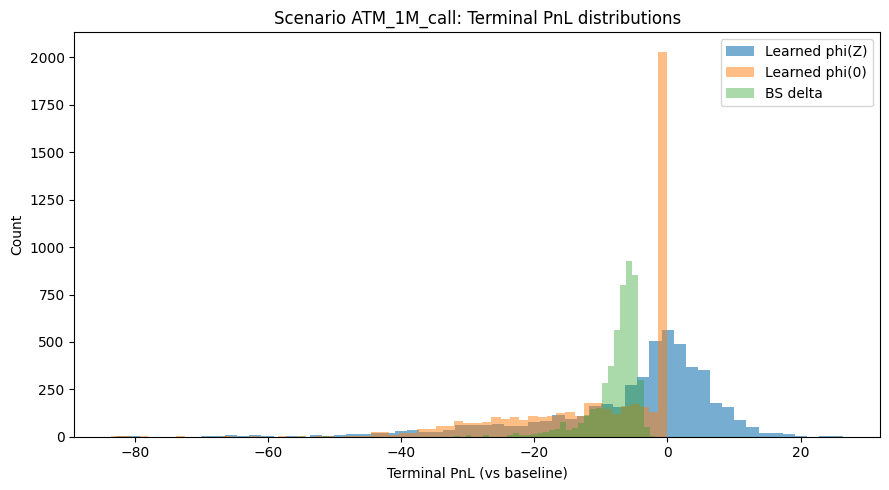


=== Running scenario: OTM5_1M_call ===
  OTM5_1M_call: K=245.57, T=22d, qty=1.0, premium=0.8680

Monetary Summary (PnL vs baseline = initial_cash + total premium)
                  mean        std         5%    median        95%   VaR(95%)  \
learned_phiZ  0.266867  17.513134 -32.837891  5.159180  20.401221  32.837891   
learned_phi0 -4.632209   8.590624 -22.609375 -0.020996   0.009766  22.609375   
bs_delta     -3.338515   3.370397  -9.882812 -2.187012  -0.469287   9.882812   

              CVaR(95%)  
learned_phiZ  45.262878  
learned_phi0  30.639399  
bs_delta      13.861487  


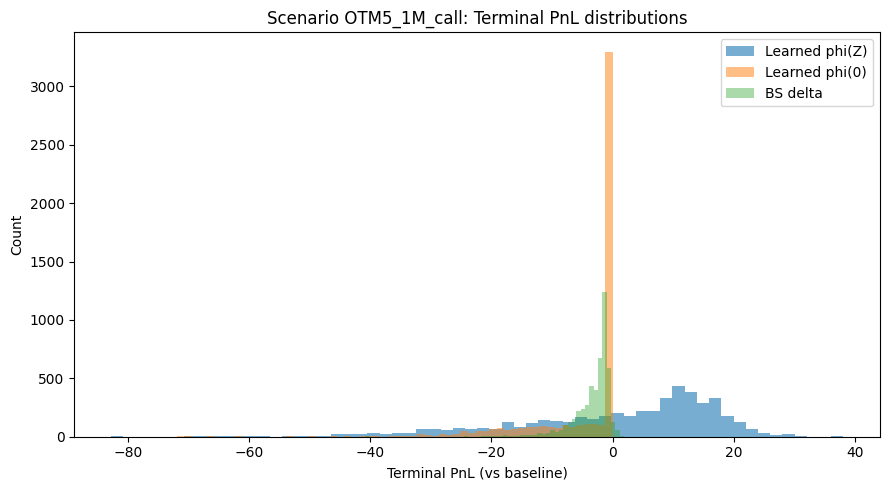


=== Running scenario: OTM10_1M_call ===
  OTM10_1M_call: K=257.26, T=22d, qty=1.0, premium=0.0899

Monetary Summary (PnL vs baseline = initial_cash + total premium)
                  mean        std         5%    median        95%   VaR(95%)  \
learned_phiZ  3.342910  20.510420 -32.837891  6.008789  30.949219  32.837891   
learned_phi0 -1.556168   4.987442 -10.916016 -0.006836   0.024414  10.916016   
bs_delta     -1.224461   2.321609  -5.740234 -0.243164   0.028320   5.740234   

              CVaR(95%)  
learned_phiZ  45.262901  
learned_phi0  18.945780  
bs_delta       9.067879  

=== Running scenario: ATM_5D_call ===
  ATM_5D_call: K=233.87, T=5d, qty=1.0, premium=2.0872

Monetary Summary (PnL vs baseline = initial_cash + total premium)
                  mean        std         5%    median        95%   VaR(95%)  \
learned_phiZ  1.076657  20.450619 -34.569336  2.573730  30.987305  34.569336   
learned_phi0 -3.822420   5.347937 -15.318359 -1.195312   0.019531  15.318359   
bs_delta

In [ ]:
    # === Extra test suite on different single-option contracts ===
test_suite_results = run_full_testing_suite(results,
                                                initial_cash=10000.0,
                                                epsilon=DEFAULTS['epsilon'],
                                                plot_first_scenarios=2)


Loaded AAPL prices: 2515 days; price column: Close
Loaded AAPL prices: 230 days; price column: Close

Using max expiry as steps = 22 days
Holdout window: 2024-11-27T00:00:00.000000000 to 2024-12-30T00:00:00.000000000 length 22
Training pool size (days): 2493
S_train_paths shape: (12000, 23)

Training hedger for Z=0 (to approximate phi(0)) ...


/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/610653124.py:1383: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0_for_sim = float(S_train_all[-1])


Epoch 1/120 last_batch_loss = 0.887286
Epoch 10/120 last_batch_loss = 0.733487
Epoch 20/120 last_batch_loss = 0.585167
Epoch 30/120 last_batch_loss = 0.564126
Epoch 40/120 last_batch_loss = 0.547978
Epoch 50/120 last_batch_loss = 0.485084
Epoch 60/120 last_batch_loss = 0.431494
Epoch 70/120 last_batch_loss = 0.437151
Epoch 80/120 last_batch_loss = 0.335977
Epoch 90/120 last_batch_loss = 0.417553
Epoch 100/120 last_batch_loss = 0.423080
Epoch 110/120 last_batch_loss = 0.357486
Epoch 120/120 last_batch_loss = 0.324247
Finished training hedger_zero.

Training hedger for portfolio payoff Z (to approximate phi(Z)) ...
Epoch 1/120 last_batch_loss = 84.393845
Epoch 10/120 last_batch_loss = 75.667297
Epoch 20/120 last_batch_loss = 76.974083
Epoch 30/120 last_batch_loss = 83.764702
Epoch 40/120 last_batch_loss = 78.179047
Epoch 50/120 last_batch_loss = 79.781586
Epoch 60/120 last_batch_loss = 81.307495
Epoch 70/120 last_batch_loss = 92.128273
Epoch 80/120 last_batch_loss = 81.241280
Epoch 90/12

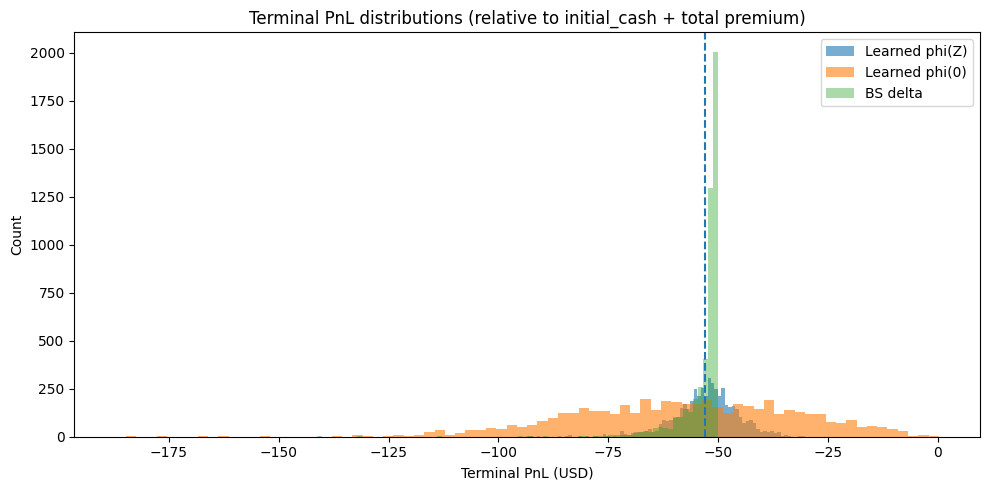

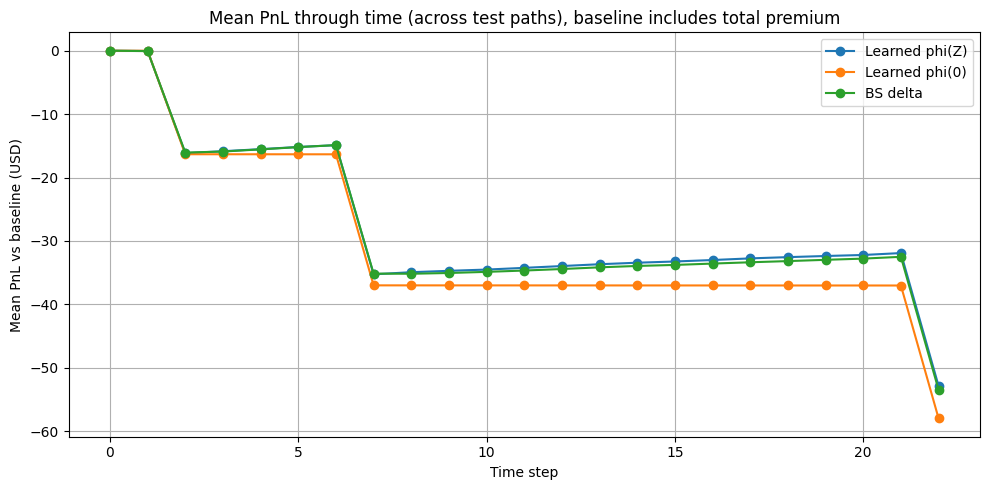

/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/610653124.py:855: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


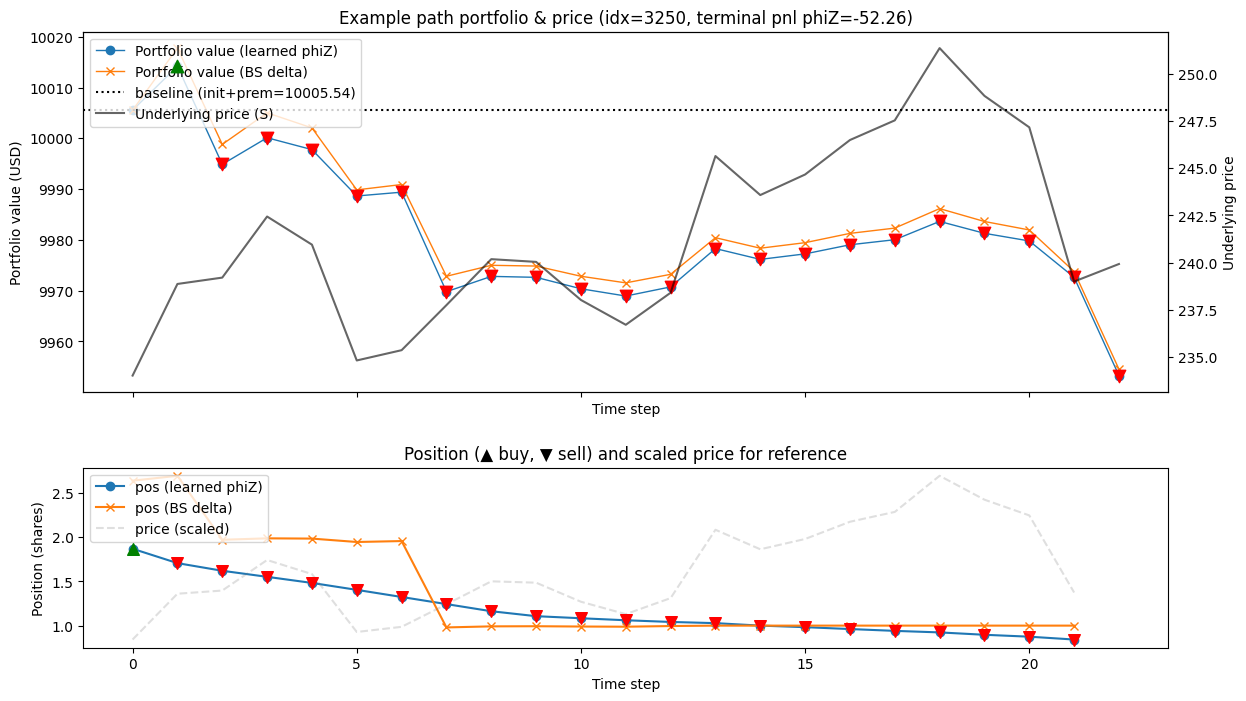

Saved terminal pnl csv: monetary_test_terminal_pnls_portfolio.csv

=== CASH-CENTRIC SUMMARY (baseline = initial_cash + total premium) ===
              mean_final_cash  std_final_cash  median_final_cash  \
learned_phiZ      9952.670898        7.511864        9953.277344   
learned_phi0      9947.555664       25.586420        9948.424805   
bs_delta          9952.050781        6.045614        9954.188477   

              5%_final_cash  95%_final_cash  mean_pnl_vs_baseline  
learned_phiZ    9939.711914     9963.830078            -52.864948  
learned_phi0    9904.785156     9987.000977            -57.981251  
bs_delta        9942.385742     9954.857422            -53.484901  


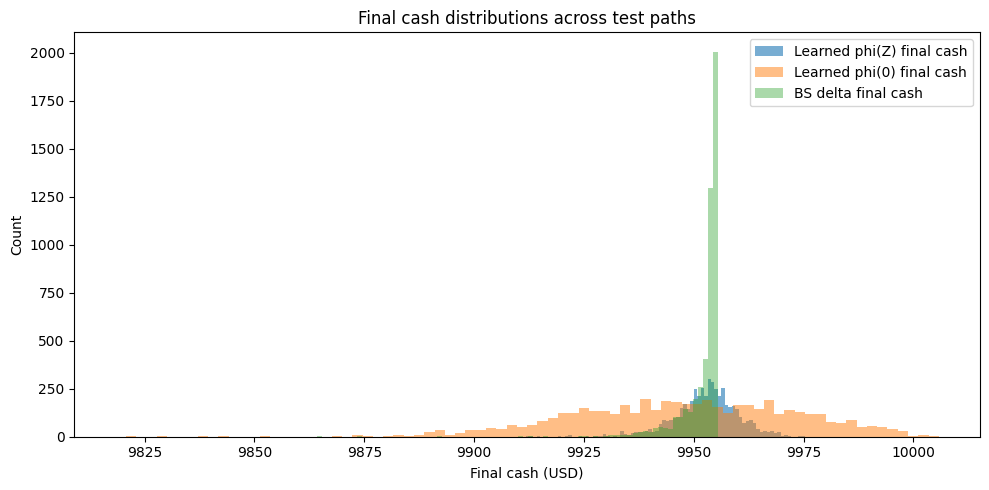

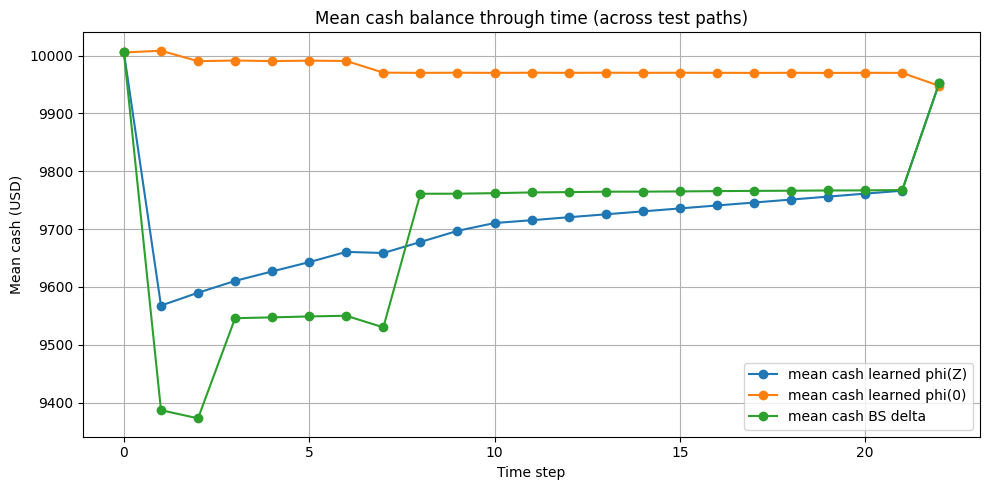

Saved cash_final_summary_portfolio.csv
Single REAL path: 2025-07-16 → 2025-12-02, length=98 (requested [2025-07-16, 2025-12-02], available [2025-01-02, 2025-12-02])
Built REAL portfolio of 4 options from t0=2025-07-16, expiry ≤ 2025-12-02, min_volume=10

=== REAL OPTIONS PORTFOLIO USED (from options_df) ===
              contractID symbol       date expiration  strike  type  mark  \
64   AAPL250718C00212500   AAPL 2025-07-16 2025-07-18   212.5  call  0.73   
66   AAPL250718C00215000   AAPL 2025-07-16 2025-07-18   215.0  call  0.26   
192  AAPL250725C00215000   AAPL 2025-07-16 2025-07-25   215.0  call  1.41   
62   AAPL250718C00210000   AAPL 2025-07-16 2025-07-18   210.0  call  1.75   

      bid   ask  volume open_interest  
64   0.72  0.74   84378         29352  
66   0.25  0.26   70571         65124  
192  1.40  1.42   69649         21498  
62   1.70  1.79   68186         46394  
(showing up to 20 of 4 rows)


/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



=== REAL SCENARIO RESULTS (single path) ===
Learned hedger terminal PnL vs baseline = 84.5605
BS delta terminal PnL vs baseline       = nan


/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/610653124.py:1352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


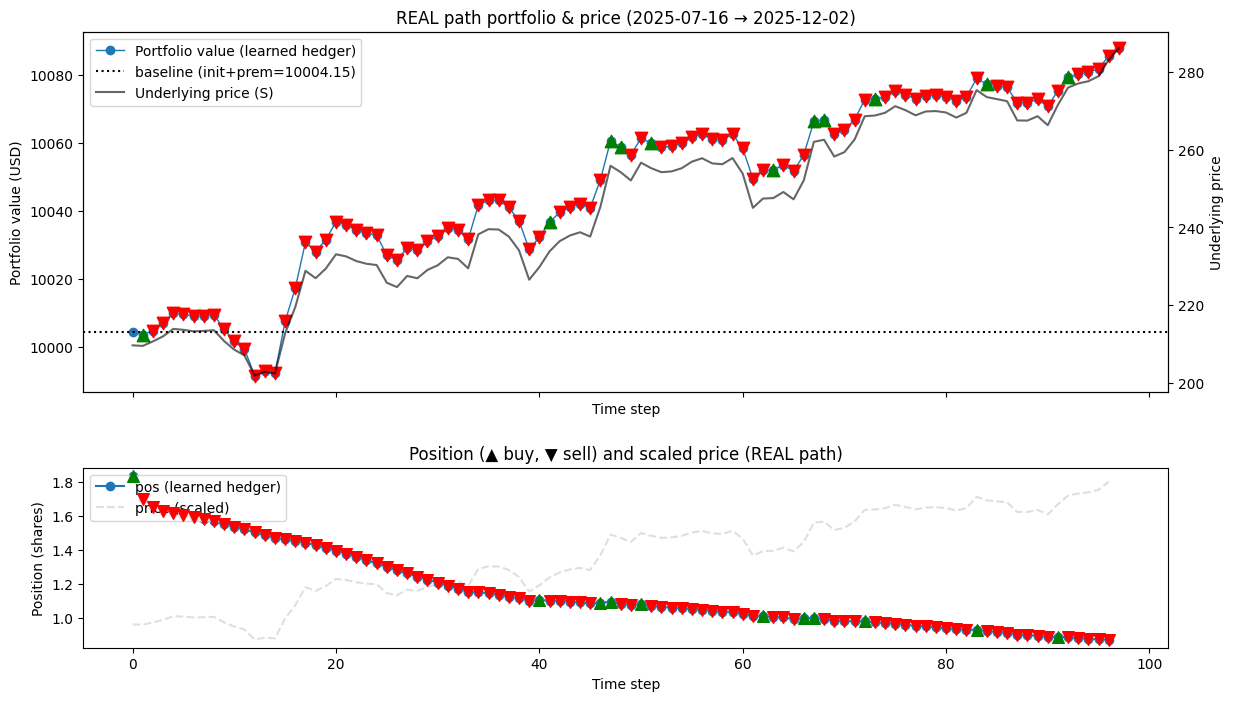

In [36]:
# deep_hedging_refactor_paper_aligned.py
# Requirements: numpy, pandas, tensorflow, matplotlib, scipy, yfinance
# pip install numpy pandas tensorflow matplotlib scipy yfinance

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import warnings
import logging

# ----------------------------
# Logging / TF noise suppression
# ----------------------------
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

# ----------------------------
# Defaults / Hyperparameters
# ----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DEFAULTS = dict(
    N_TRAIN_PATHS=12000,
    N_TEST_PATHS=5000,
    steps=21,               # will be set to max expiry of portfolio
    batch_size=512,
    epochs=120,
    hid_dim=64,
    learning_rate=3e-4,
    epsilon=0.001,
    alpha_cvar=0.95,
    risk_measure='cvar',    # 'cvar' or 'entropic'
    ent_lambda=1.0,
    op_dim=1,
    r_annual=0.0,
    ann_days=252.0,
)

# ----------------------------
# Market data loader / utils
# ----------------------------
class MarketData:
    def __init__(self, ticker="AAPL", start="2015-01-01", end="2025-12-31", px_col_pref=('Adj Close','Close')):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.px_col_pref = px_col_pref
        self.prices = None
        self.dates = None

    def download(self):
        df = yf.download(self.ticker, start=self.start, end=self.end, progress=False)
        for c in self.px_col_pref:
            if c in df.columns:
                px_col = c
                break
        else:
            raise RuntimeError("No price column found in downloaded data.")
        self.prices = df[px_col].values.astype(np.float32)
        self.dates = df.index.to_numpy()
        print(f"Loaded {self.ticker} prices: {self.prices.shape[0]} days; price column: {px_col}")
        return self.prices, self.dates

    @staticmethod
    def safe_log_returns(series):
        arr = np.asarray(series).ravel()
        if arr.size < 2:
            raise ValueError("Not enough prices to compute returns.")
        return np.diff(np.log(arr)).ravel()

    def build_holdout_and_pool(self, steps):
        if self.prices is None:
            raise RuntimeError("Call download() first.")
        if len(self.prices) < steps + 60:
            raise RuntimeError("Not enough historical data for chosen steps/horizon.")
        holdout_end_idx = len(self.prices) - 1
        holdout_start_idx = holdout_end_idx - steps + 1
        S_holdout = np.asarray(self.prices[holdout_start_idx:holdout_end_idx+1]).ravel()
        dates_holdout = self.dates[holdout_start_idx:holdout_end_idx+1]
        # training pool excludes holdout
        mask = np.ones(len(self.prices), dtype=bool)
        mask[holdout_start_idx:holdout_end_idx+1] = False
        S_train_pool = np.asarray(self.prices[mask]).ravel()
        print("Holdout window:", dates_holdout[0], "to", dates_holdout[-1], "length", len(S_holdout))
        print("Training pool size (days):", len(S_train_pool))
        return S_holdout, dates_holdout, S_train_pool

# ----------------------------
# Bootstrapper
# ----------------------------
class Bootstrapper:
    def __init__(self, returns_pool, seed=SEED):
        self.returns = np.asarray(returns_pool).ravel()
        self.seed = seed
        self.rng = np.random.RandomState(seed)

    def bootstrap_paths_vectorized(self, S0, n_paths, steps, seed=None):
        rng = np.random.RandomState(seed if seed is not None else self.seed)
        returns = self.returns
        n_available = returns.shape[0]
        if n_available < steps:
            raise ValueError(f"Not enough returns ({n_available}) to sample windows of length {steps}.")
        starts = rng.randint(0, n_available - steps + 1, size=n_paths)
        idx_matrix = starts[:, None] + np.arange(steps)[None, :]
        rsegs = returns[idx_matrix]        # (n_paths, steps)
        cums = np.cumsum(rsegs, axis=1)
        zeros = np.zeros((n_paths, 1), dtype=cums.dtype)
        log_prices = np.concatenate([zeros, cums], axis=1)
        paths = S0 * np.exp(log_prices).astype(np.float32)
        return paths

    def extend_paths_by_returns(self, paths, extra_days, seed=None):
        """
        paths: (N, L) numpy array of existing price paths
        returns: extended_paths (N, L + extra_days)
        """
        rng = np.random.RandomState(seed if seed is not None else self.seed)
        N, L = paths.shape
        returns = self.returns
        n_avail = returns.shape[0]
        if n_avail < extra_days:
            raise ValueError("Not enough returns in returns_pool to sample extra_days.")
        starts = rng.randint(0, n_avail - extra_days + 1, size=N)
        idx_matrix = starts[:, None] + np.arange(extra_days)[None, :]
        sampled_rets = returns[idx_matrix]            # (N, extra_days)
        cums = np.cumsum(sampled_rets, axis=1)
        S0 = paths[:, -1][:, None]                    # (N,1)
        multipliers = np.exp(cums).astype(np.float32) # (N, extra_days)
        ext_segment = S0 * multipliers                # (N, extra_days)
        extended = np.concatenate([paths, ext_segment], axis=1)
        return extended

# ----------------------------
# Option specification (fixed K, premium, maturity)
# ----------------------------
class OptionSpec:
    """
    Fixed European option contract on AAPL.
    All parameters are explicitly set (no dynamic strike choosing).
    quantity: number of options you're short (positive = you sold the options).
    premium: premium received per option at t=0.
    expiry_days: maturity in trading days counted from t=0 of your simulated path.
    """
    def __init__(self, name, K, expiry_days, premium, quantity=1.0,
                 option_type='call'):
        self.name = name
        self.K = float(K)
        self.expiry_days = int(expiry_days)
        self.premium = float(premium)
        self.quantity = float(quantity)
        self.option_type = option_type

    def payoff(self, S_terminal):
        S_terminal = np.asarray(S_terminal, dtype=np.float32)
        if self.option_type == 'call':
            return np.maximum(S_terminal - self.K, 0.0).astype(np.float32)
        else:
            return np.maximum(self.K - S_terminal, 0.0).astype(np.float32)

# ----------------------------
# Portfolio payoff helper
# ----------------------------
def portfolio_payoff(paths, option_portfolio):
    """
    paths: (N, L) price paths
    option_portfolio: list[OptionSpec]
    Returns: Z_portfolio (N,) = total short payoff across all options.
    Assumes daily steps, index 'd' approximates 'd days from t=0'.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape
    Z = np.zeros(N, dtype=np.float32)

    for opt in option_portfolio:
        # maturity index within [0, L-1]
        t_idx = min(max(opt.expiry_days, 0), L - 1)
        S_Ti = paths[:, t_idx]
        payoff_i = opt.payoff(S_Ti)          # shape (N,)
        Z += opt.quantity * payoff_i         # short q_i options => total liability

    return Z.astype(np.float32)

# ----------------------------
# Feature builder
# ----------------------------
def build_features(paths):
    N, L = paths.shape
    timesteps = L - 1
    feat = np.zeros((N, L, 2), dtype=np.float32)
    feat[:, :, 0] = np.log(paths)
    tt = np.arange(timesteps, -1, -1) / float(timesteps)  # 1.0 .. 0.0
    feat[:, :, 1] = tt[np.newaxis, :]
    return feat

# ----------------------------
# Hedger network
# ----------------------------
class HedgerNet:
    def __init__(self, input_dim=3, hid_dim=64, op_dim=1, lr=3e-4):
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.op_dim = op_dim
        self.lr = lr
        self.model = self._build_model()
        self.optimizer = optimizers.Adam(learning_rate=self.lr)

    def _build_model(self):
        inp = layers.Input(shape=(self.input_dim,), dtype=tf.float32)
        x = layers.Dense(self.hid_dim, activation="relu")(inp)
        x = layers.Dense(self.hid_dim, activation="relu")(x)
        out = layers.Dense(self.op_dim, activation=None)(x)
        model = Model(inp, out)
        return model

# ----------------------------
# Trainer (TF training with CVaR / entropic objective)
# ----------------------------
class Trainer:
    def __init__(self, hedger: HedgerNet, feat_train, asset_train, Z_train,
                 alpha_cvar=0.95, epsilon=0.0, risk_measure='cvar'):
        self.hedger = hedger
        self.feat_tensor = tf.constant(feat_train)
        self.asset_tensor = tf.constant(asset_train.astype(np.float32))
        self.Zb = tf.constant(Z_train.astype(np.float32))
        self.alpha_cvar = alpha_cvar
        self.epsilon = epsilon
        self.risk_measure = risk_measure
        self.ent_lambda = DEFAULTS['ent_lambda']

    @staticmethod
    @tf.function
    def cvar_tf(terminal_pnl, alpha=0.95):
        loss = -terminal_pnl
        loss_sorted = tf.sort(loss)
        n = tf.shape(loss_sorted)[0]
        idx = tf.cast(tf.math.floor(alpha * tf.cast(n, tf.float32)), tf.int32)
        idx = tf.clip_by_value(idx, 0, n-1)
        var_a = loss_sorted[idx]
        tail = tf.boolean_mask(loss, loss >= var_a)
        return tf.cond(tf.equal(tf.size(tail), 0),
                       lambda: tf.reduce_mean(loss),
                       lambda: tf.reduce_mean(tail))

    @staticmethod
    @tf.function
    def entropic_tf(terminal_pnl, lam=1.0, clip_low=-50.0, clip_high=50.0):
        X = terminal_pnl
        if lam <= 0.0:
            # lam -> 0 limit is just -E[X] (up to constant), but we guard against 0.
            return -tf.reduce_mean(X)

        x = -lam * X
        x = tf.clip_by_value(x, clip_low, clip_high)       # numerical stability
        m = tf.reduce_mean(tf.exp(x))
        return (1.0 / lam) * tf.math.log(m + 1e-30)

    @tf.function
    def forward_train(self, batch_idx):
        Fe = tf.gather(self.feat_tensor, batch_idx)
        Asset = tf.gather(self.asset_tensor, batch_idx)
        Z = tf.gather(self.Zb, batch_idx)
        B = tf.shape(Fe)[0]
        L = tf.shape(Fe)[1]
        prev_pos = tf.zeros((B,1), dtype=tf.float32)
        pnl = tf.zeros((B,), dtype=tf.float32)
        cum_cost = tf.zeros((B,), dtype=tf.float32)
        for t in tf.range(L-1):
            logS = Fe[:, t, 0]
            tt = Fe[:, t, 1]
            inp = tf.stack([logS, tt, tf.reshape(prev_pos, [B])], axis=1)
            new_pos = self.hedger.model(inp)
            S_t = Asset[:, t]
            trade = tf.reshape(new_pos, [B]) - tf.reshape(prev_pos, [B])
            cost = self.epsilon * tf.abs(trade) * S_t
            cum_cost += cost
            dS = Asset[:, t+1] - Asset[:, t]
            pnl += tf.reshape(prev_pos, [B]) * dS
            prev_pos = new_pos
        S_T = Asset[:, -1]
        final_trade = -tf.reshape(prev_pos, [B])
        cum_cost += self.epsilon * tf.abs(final_trade) * S_T
        terminal_pnl = -Z + pnl - cum_cost

        if self.risk_measure == 'entropic':
            loss = Trainer.entropic_tf(terminal_pnl, lam=self.ent_lambda)
        else:
            loss = Trainer.cvar_tf(terminal_pnl, alpha=self.alpha_cvar)
        return loss, terminal_pnl

    def train(self, epochs, batch_size, verbose=True):
        n_train = int(self.asset_tensor.shape[0])
        indices = np.arange(n_train, dtype=np.int32)
        loss_history = []
        for epoch in range(epochs):
            np.random.shuffle(indices)
            last_loss = 0.0
            for start in range(0, n_train, batch_size):
                batch_idx = tf.constant(indices[start:start+batch_size], dtype=tf.int32)
                with tf.GradientTape() as tape:
                    loss_val, _ = self.forward_train(batch_idx)
                grads = tape.gradient(loss_val, self.hedger.model.trainable_variables)
                grads = [g if g is not None else tf.zeros_like(v) for g, v in zip(grads, self.hedger.model.trainable_variables)]
                grads, _ = tf.clip_by_global_norm(grads, 1.0)
                self.hedger.optimizer.apply_gradients(zip(grads, self.hedger.model.trainable_variables))
                last_loss = float(loss_val.numpy())
            loss_history.append(last_loss)
            if verbose and ((epoch+1) % 10 == 0 or epoch == 0):
                print(f"Epoch {epoch+1}/{epochs} last_batch_loss = {last_loss:.6f}")
        return loss_history

# ----------------------------
# Evaluator
# ----------------------------
class Evaluator:
    def __init__(self, hedger_model: Model, epsilon=0.0):
        self.hedger_model = hedger_model
        self.epsilon = epsilon

    def evaluate_policy_with_payoff(self, paths, Z_array, batch_size=512):
        """
        Evaluate hedger_model on given price paths and *custom* payoff samples Z_array.
        Returns: terminal_pnls (N,), hedge_trajs (N, L-1)
        This preserves convention terminal P&L = -Z + pnl - cum_cost
        """
        N, L = paths.shape
        terminal_pnls = np.zeros(N, dtype=np.float32)
        hedge_trajs = np.zeros((N, L-1), dtype=np.float32)
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            B = end - start
            batch_paths = paths[start:end]
            prev_pos = np.zeros(B, dtype=np.float32)
            pnl = np.zeros(B, dtype=np.float32)
            cum_cost = np.zeros(B, dtype=np.float32)
            for t in range(L-1):
                logS = np.log(batch_paths[:, t]).astype(np.float32)
                tt = np.full(B, float((L-1 - t) / (L-1)), dtype=np.float32)
                inp = np.column_stack([logS, tt, prev_pos]).astype(np.float32)
                new_pos = self.hedger_model.predict(inp, batch_size=B, verbose=0).reshape(-1)
                trade = new_pos - prev_pos
                cost = self.epsilon * np.abs(trade) * batch_paths[:, t]
                cum_cost += cost
                dS = batch_paths[:, t+1] - batch_paths[:, t]
                pnl += prev_pos * dS
                prev_pos = new_pos
                hedge_trajs[start:end, t] = prev_pos
            final_trade = -prev_pos
            cum_cost += self.epsilon * np.abs(final_trade) * batch_paths[:, -1]
            terminal_pnls[start:end] = -Z_array[start:end] + pnl - cum_cost
        return terminal_pnls, hedge_trajs

    @staticmethod
    def bs_delta_call(S, K, Ttm, r, sigma):
        if Ttm <= 0 or sigma <= 0:
            return 0.0 if S <= K else 1.0
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * Ttm) / (sigma * np.sqrt(Ttm) + 1e-12)
        return norm.cdf(d1)

# ----------------------------
# Indifference pricer
# ----------------------------
class IndifferencePricer:
    def __init__(self, measure='cvar', ent_lambda=1.0, alpha_cvar=0.95):
        self.measure = measure
        self.ent_lambda = ent_lambda
        self.alpha_cvar = alpha_cvar

    @staticmethod
    def rho_entropic_from_sample(X_samples, lam, clip=(-50,50)):
        x = -lam * X_samples
        x = np.clip(x, clip[0], clip[1])
        m = np.mean(np.exp(x))
        return (1.0/lam) * np.log(m + 1e-30)

    @staticmethod
    def rho_cvar_from_sample(X_samples, alpha):
        losses = -X_samples
        sorted_losses = np.sort(losses)
        N = sorted_losses.shape[0]
        idx = int(np.floor(alpha * float(N)))
        idx = max(0, min(idx, N-1))
        var_a = sorted_losses[idx]
        tail = sorted_losses[sorted_losses >= var_a]
        if tail.size == 0:
            return np.mean(losses)
        return np.mean(tail)

    def estimate_rho_from_sample_np(self, X_samples):
        if self.measure == 'entropic':
            return IndifferencePricer.rho_entropic_from_sample(X_samples, self.ent_lambda)
        elif self.measure == 'cvar':
            return IndifferencePricer.rho_cvar_from_sample(X_samples, self.alpha_cvar)
        else:
            return -np.mean(X_samples)

    def indifference_price(self, term_pnls, Z_test):
        """
        Return (p, rho_X, rho_X_minusZ) with conventional sign:
            term_pnls := X - Z
            Z_test := Z
            rho_X_minusZ = rho(X - Z)
            rho_X = rho(X)
            p = rho_X - rho_X_minusZ
        """
        rho_X_minusZ = self.estimate_rho_from_sample_np(term_pnls)          # rho(X - Z)
        rho_X = self.estimate_rho_from_sample_np(term_pnls + Z_test)        # rho(X)
        p = rho_X - rho_X_minusZ
        return p, rho_X, rho_X_minusZ

    def bootstrap_indifference(self, term_pnls, Z_test, B=500, seed=SEED):
        rng = np.random.RandomState(seed)
        N = term_pnls.shape[0]
        boot_p = np.empty(B, dtype=np.float64)
        for b in range(B):
            idx = rng.randint(0, N, size=N)
            s_term = term_pnls[idx]
            s_Z = Z_test[idx]
            s_pi_minusZ = self.estimate_rho_from_sample_np(s_term)
            s_pi_0 = self.estimate_rho_from_sample_np(s_term + s_Z)
            boot_p[b] = s_pi_0 - s_pi_minusZ
        mean_p = boot_p.mean()
        se = boot_p.std(ddof=1)
        ci_low, ci_high = np.percentile(boot_p, [2.5, 97.5])
        return mean_p, se, (ci_low, ci_high), boot_p

# ----------------------------
# Multi-option portfolio simulator (money, with premiums)
# ----------------------------
def simulate_portfolio_money_on_paths(paths, hedger_model, option_portfolio,
                                      initial_cash=10000.0, epsilon=0.0):
    """
    Simulate selling a fixed portfolio of options on AAPL at t=0 and hedging
    with 'hedger_model'. All options are on the same underlying 'paths'.

    - Each OptionSpec in option_portfolio defines K, expiry_days, premium, quantity.
    - We assume you're SHORT `quantity` options => receive premium, pay payoff.
    - We include all premiums in the starting cash (baseline) exactly like before.

    Returns dict with portfolio_values_time, cash_time, pos_time, trades_time,
    terminal_pnls (relative to initial_cash + total premium), hedge_costs,
    option_payoffs_total, option_payoffs_per_option, premium_total, baseline.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape

    # precompute expiry indices per option
    opt_maturity_idx = {
        opt.name: min(max(opt.expiry_days, 0), L - 1)
        for opt in option_portfolio
    }

    # premiums
    premium_total = float(sum(opt.quantity * opt.premium
                              for opt in option_portfolio))
    initial_cash_arr = np.full(N, float(initial_cash + premium_total),
                               dtype=np.float32)

    portfolio_values_time = np.zeros((N, L), dtype=np.float32)
    cash_time = np.zeros((N, L), dtype=np.float32)
    pos_time = np.zeros((N, L-1), dtype=np.float32)
    trades_time = np.zeros((N, L-1), dtype=np.float32)
    hedge_costs = np.zeros(N, dtype=np.float32)
    option_payoffs_total = np.zeros(N, dtype=np.float32)
    option_payoffs_per_option = {
        opt.name: np.zeros(N, dtype=np.float32) for opt in option_portfolio
    }

    Bsize = 512
    for start in range(0, N, Bsize):
        end = min(start + Bsize, N)
        B = end - start
        batch_paths = paths[start:end]
        cash = initial_cash_arr[start:end].copy()
        prev_pos = np.zeros(B, dtype=np.float32)
        cum_cost = np.zeros(B, dtype=np.float32)

        # t=0 portfolio value
        portfolio_values_time[start:end, 0] = cash + prev_pos * batch_paths[:, 0]
        cash_time[start:end, 0] = cash

        for t in range(L - 1):
            S_t = batch_paths[:, t]
            S_next = batch_paths[:, t + 1]

            # hedging input: (logS, time-to-max-expiry, prev_pos)
            logS = np.log(S_t).astype(np.float32)
            tt = np.full(B, float((L - 1 - t) / (L - 1)), dtype=np.float32)
            inp = np.column_stack([logS, tt, prev_pos]).astype(np.float32)

            new_pos = hedger_model.predict(inp, batch_size=B, verbose=0).reshape(-1)

            trade = new_pos - prev_pos
            cost = epsilon * np.abs(trade) * S_t
            cash -= trade * S_t
            cash -= cost
            cum_cost += cost

            pos_time[start:end, t] = new_pos
            trades_time[start:end, t] = trade

            # mark-to-market portfolio value (before any option expiry cash flows)
            portfolio_values_time[start:end, t+1] = cash + new_pos * S_next
            cash_time[start:end, t+1] = cash

            prev_pos = new_pos

            # --- Handle any option maturities at time index t+1 ---
            for opt in option_portfolio:
                if opt_maturity_idx[opt.name] == (t + 1):
                    payoff = opt.payoff(S_next) * opt.quantity   # (B,)
                    option_payoffs_per_option[opt.name][start:end] += payoff
                    option_payoffs_total[start:end] += payoff
                    cash -= payoff   # we are short => we pay

                    # update cash & portfolio value after paying payoff
                    cash_time[start:end, t+1] = cash
                    portfolio_values_time[start:end, t+1] = cash + prev_pos * S_next

        # final liquidation at time L-1
        ST = batch_paths[:, -1]
        final_trade = -prev_pos
        final_cost = epsilon * np.abs(final_trade) * ST
        cash -= final_trade * ST
        cash -= final_cost
        cum_cost += final_cost

        hedge_costs[start:end] = cum_cost
        portfolio_values_time[start:end, -1] = cash
        cash_time[start:end, -1] = cash

    baseline = float(initial_cash + premium_total)
    terminal_values = portfolio_values_time[:, -1]
    terminal_pnls = terminal_values - baseline

    return {
        'portfolio_values_time': portfolio_values_time,
        'cash_time': cash_time,
        'pos_time': pos_time,
        'trades_time': trades_time,
        'terminal_pnls': terminal_pnls,
        'hedge_costs': hedge_costs,
        'option_payoffs_total': option_payoffs_total,
        'option_payoffs_per_option': option_payoffs_per_option,
        'premium_total': premium_total,
        'baseline': baseline,
    }

# ----------------------------
# BS delta portfolio baseline (same baseline convention)
# ----------------------------
def _run_bs_portfolio_delta_on_paths_with_premium(paths, option_portfolio,
                                                  rv_annual, initial_cash,
                                                  epsilon):
    """
    Black-Scholes delta hedge of the same multi-option portfolio.
    - Uses portfolio delta = sum q_i * delta_i per option.
    - Receives premium_total at t=0, same as simulate_portfolio_money_on_paths.
    """
    paths = np.asarray(paths, dtype=np.float32)
    N, L = paths.shape

    premium_total = float(sum(opt.quantity * opt.premium
                              for opt in option_portfolio))
    baseline = float(initial_cash + premium_total)
    initial_cash_arr = np.full(N, baseline, dtype=np.float32)

    portfolio_values_time = np.zeros((N, L), dtype=np.float32)
    cash_time = np.zeros((N, L), dtype=np.float32)
    pos_time = np.zeros((N, L-1), dtype=np.float32)
    trades_time = np.zeros((N, L-1), dtype=np.float32)
    hedge_costs = np.zeros(N, dtype=np.float32)
    payoff_arr_total = np.zeros(N, dtype=np.float32)
    payoff_per_option = {
        opt.name: np.zeros(N, dtype=np.float32) for opt in option_portfolio
    }

    # expiry indices
    opt_maturity_idx = {
        opt.name: min(max(opt.expiry_days, 0), L-1) for opt in option_portfolio
    }

    for i in range(N):
        cash = initial_cash_arr[i]
        prev_pos = 0.0
        portfolio_values_time[i,0] = cash
        cash_time[i,0] = cash

        for t in range(L-1):
            S_t = float(paths[i,t])

            # portfolio delta: sum q_i * delta_i
            portfolio_delta = 0.0
            for opt in option_portfolio:
                days_to_maturity = max(opt.expiry_days - t, 0)
                if days_to_maturity <= 0:
                    continue
                Ttm_years = float(days_to_maturity / DEFAULTS['ann_days'])
                delta_i = Evaluator.bs_delta_call(S_t, opt.K, Ttm_years,
                                                  DEFAULTS['r_annual'], rv_annual)
                portfolio_delta += opt.quantity * delta_i

            trade = portfolio_delta - prev_pos
            cost = epsilon * abs(trade) * S_t
            cash -= trade * S_t
            cash -= cost
            hedge_costs[i] += cost

            pos_time[i,t] = portfolio_delta
            trades_time[i,t] = trade
            prev_pos = portfolio_delta

            S_next = float(paths[i,t+1])
            portfolio_values_time[i,t+1] = cash + prev_pos * S_next
            cash_time[i,t+1] = cash

            # handle expiries at t+1
            for opt in option_portfolio:
                if opt_maturity_idx[opt.name] == (t+1):
                    payoff = float(opt.payoff(np.array([S_next]))[0] * opt.quantity)
                    payoff_per_option[opt.name][i] += payoff
                    payoff_arr_total[i] += payoff
                    cash -= payoff
                    cash_time[i,t+1] = cash
                    portfolio_values_time[i,t+1] = cash + prev_pos * S_next

        # final liquidation
        ST = float(paths[i,-1])
        final_trade = -prev_pos
        final_cost = epsilon * abs(final_trade) * ST
        cash -= final_trade * ST
        cash -= final_cost
        hedge_costs[i] += final_cost
        portfolio_values_time[i,-1] = cash
        cash_time[i,-1] = cash

    terminal_values = portfolio_values_time[:,-1]
    terminal_pnls = terminal_values - baseline
    return {
        'portfolio_values_time': portfolio_values_time,
        'cash_time': cash_time,
        'pos_time': pos_time,
        'trades_time': trades_time,
        'terminal_pnls': terminal_pnls,
        'hedge_costs': hedge_costs,
        'option_payoffs_total': payoff_arr_total,
        'option_payoffs_per_option': payoff_per_option,
        'premium_total': premium_total,
        'baseline': baseline,
    }

# ----------------------------
# Terminal PnL summarizer
# ----------------------------
def summarize_terminal_pnls(term_pnls):
    """
    returns pandas Series of summary statistics of money P&L
    terminal_pnls should already be relative to baseline (initial_cash + premium)
    """
    s = pd.Series(term_pnls)
    stats = {
        'count': s.count(),
        'mean': float(s.mean()),
        'std': float(s.std(ddof=1)),
        'min': float(s.min()),
        '5%': float(s.quantile(0.05)),
        'median': float(s.median()),
        '95%': float(s.quantile(0.95)),
        'max': float(s.max()),
        'VaR(95%)': float(-s.quantile(0.05)),   # From loss perspective
        'CVaR(95%)': None
    }
    # CVaR 95% calculation
    q05 = s.quantile(0.05)
    tail = s[s <= q05]
    if len(tail) > 0:
        stats['CVaR(95%)'] = float(-tail.mean())
    else:
        stats['CVaR(95%)'] = float(-s.mean())
    return pd.Series(stats)

# ----------------------------
# Monetary test report (portfolio version)
# ----------------------------
def monetary_test_report(results, initial_cash=10000.0):
    """
    Uses simulate_portfolio_money_on_paths to:
      - simulate and include total premium up-front in cash/portfolio flows
      - print money summary (terminal P&L relative to initial_cash + total premium)
      - plot terminal histograms and mean P&L through time relative to baseline
      - plot example path with buy (▲) and sell (▼) markers
    """
    hedger_Z = results['hedger_Z'].model
    hedger_zero = results['hedger_zero'].model
    S_test_paths = results['S_test_paths']
    Z_test = results['Z_test']
    option_portfolio = results['option_portfolio']
    epsilon = DEFAULTS['epsilon']

    print("\n=== OPTION PORTFOLIO USED ===")
    for opt in option_portfolio:
        print(f"  {opt.name}: K={opt.K:.2f}, T={opt.expiry_days}d, "
              f"qty={opt.quantity}, premium={opt.premium:.2f}")

    # simulate money for both hedgers on the test paths
    sim_Z = simulate_portfolio_money_on_paths(
        S_test_paths, hedger_Z, option_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )
    sim_zero = simulate_portfolio_money_on_paths(
        S_test_paths, hedger_zero, option_portfolio,
        initial_cash=initial_cash, epsilon=epsilon
    )

    # Black-Scholes delta baseline (portfolio)
    # realized vol from train pool / holdout proxy
    rv_annual = np.std(
        np.diff(np.log(results.get('S_holdout')
                       if results.get('S_holdout') is not None
                       else S_test_paths[:,0]))
    ) * np.sqrt(DEFAULTS['ann_days'])

    sim_bs = _run_bs_portfolio_delta_on_paths_with_premium(
        S_test_paths, option_portfolio, rv_annual,
        initial_cash, epsilon
    )

    premium_total = sim_Z['premium_total']
    print(f"\nTotal premium received for portfolio = {premium_total:.2f}")

    # Summaries (terminal_pnls are relative to baseline = initial_cash + premium_total)
    sum_Z = summarize_terminal_pnls(sim_Z['terminal_pnls'])
    sum_zero = summarize_terminal_pnls(sim_zero['terminal_pnls'])
    sum_bs = summarize_terminal_pnls(sim_bs['terminal_pnls'])

    summary_df = pd.DataFrame({
        'learned_phiZ': sum_Z,
        'learned_phi0': sum_zero,
        'bs_delta': sum_bs
    })

    print("\n=== Monetary Test Summary (terminal PnL vs initial_cash + total premium) ===")
    print(summary_df.T[['mean','std','5%','median','95%','VaR(95%)','CVaR(95%)']])
    print(f"Baseline (initial_cash + total premium) = {initial_cash + premium_total:.2f}")

    # Plot terminal histograms
    plt.figure(figsize=(10,5))
    plt.hist(sim_Z['terminal_pnls'], bins=80, alpha=0.6, label='Learned phi(Z)')
    plt.hist(sim_zero['terminal_pnls'], bins=80, alpha=0.6, label='Learned phi(0)')
    plt.hist(sim_bs['terminal_pnls'], bins=80, alpha=0.4, label='BS delta')
    plt.axvline(summary_df.loc['mean','learned_phiZ'], linestyle='--')
    plt.legend()
    plt.title("Terminal PnL distributions (relative to initial_cash + total premium)")
    plt.xlabel("Terminal PnL (USD)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Plot cumulative mean PnL through time relative to baseline
    baseline = sim_Z['baseline']  # initial_cash + premium_total
    mean_pnl_Z = (sim_Z['portfolio_values_time'] - baseline).mean(axis=0)
    mean_pnl_zero = (sim_zero['portfolio_values_time'] - baseline).mean(axis=0)
    mean_pnl_bs = (sim_bs['portfolio_values_time'] - baseline).mean(axis=0)
    timesteps = np.arange(sim_Z['portfolio_values_time'].shape[1])

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, mean_pnl_Z, '-o', label='Learned phi(Z)')
    plt.plot(timesteps, mean_pnl_zero, '-o', label='Learned phi(0)')
    plt.plot(timesteps, mean_pnl_bs, '-o', label='BS delta')
    plt.xlabel("Time step")
    plt.ylabel("Mean PnL vs baseline (USD)")
    plt.title("Mean PnL through time (across test paths), baseline includes total premium")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Example single path plot WITH underlying price
    idx_med = int(np.argsort(sim_Z['terminal_pnls'])[len(sim_Z['terminal_pnls'])//2])

    pv_phi = sim_Z['portfolio_values_time'][idx_med]   # length L
    pv_bs  = sim_bs['portfolio_values_time'][idx_med]
    pos_phi = sim_Z['pos_time'][idx_med]               # length L-1
    trades_phi = sim_Z['trades_time'][idx_med]
    pos_bs = sim_bs['pos_time'][idx_med]
    trades_bs = sim_bs['trades_time'][idx_med]
    price_path = S_test_paths[idx_med]                 # length L
    L = len(price_path)
    times = np.arange(L)

    fig = plt.figure(figsize=(14,8))
    gs = fig.add_gridspec(2,1, height_ratios=[2,1], hspace=0.28)

    # --- Top: portfolio values + underlying price (twin y axis) ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(times, pv_phi, '-o', label='Portfolio value (learned phiZ)', linewidth=1)
    ax0.plot(times, pv_bs,  '-x', label='Portfolio value (BS delta)', linewidth=1)
    ax0.axhline(baseline, color='k', linestyle=':', label=f'baseline (init+prem={baseline:.2f})')

    for t in range(L-1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            m_x = t+1
            m_y = pv_phi[m_x]
            if tr > 0:
                ax0.scatter(m_x, m_y, marker='^', color='green', s=80, zorder=6, label='_nolegend_')  # buy
            else:
                ax0.scatter(m_x, m_y, marker='v', color='red', s=80, zorder=6, label='_nolegend_')    # sell

    axp = ax0.twinx()
    axp.plot(times, price_path, '-k', alpha=0.6, label='Underlying price (S)')
    axp.set_ylabel('Underlying price', color='k')
    axp.tick_params(axis='y', labelcolor='k')

    ax0.set_ylabel('Portfolio value (USD)')
    ax0.set_title(f"Example path portfolio & price (idx={idx_med}, terminal pnl phiZ={sim_Z['terminal_pnls'][idx_med]:.2f})")
    ax0.set_xlabel('Time step')

    handles0, labels0 = ax0.get_legend_handles_labels()
    handles1, labels1 = axp.get_legend_handles_labels()
    ax0.legend(handles0 + handles1, labels0 + labels1, loc='upper left')

    # --- Bottom: positions + trade markers, with scaled price ---
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    times_pos = np.arange(L-1)
    ax1.plot(times_pos, pos_phi, '-o', label='pos (learned phiZ)')
    ax1.plot(times_pos, pos_bs,  '-x', label='pos (BS delta)')

    p_min, p_max = price_path.min(), price_path.max()
    pos_ymin, pos_ymax = np.min([pos_phi.min(), pos_bs.min()]), np.max([pos_phi.max(), pos_bs.max()])
    if (p_max - p_min) > 1e-12 and (pos_ymax - pos_ymin) > 1e-12:
        price_scaled = (price_path[:-1] - p_min) / (p_max - p_min + 1e-12) * (pos_ymax - pos_ymin) + pos_ymin
        ax1.plot(times_pos, price_scaled, '--', color='gray', alpha=0.25, label='price (scaled)')

    for t in range(L-1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            if tr > 0:
                ax1.scatter(t, pos_phi[t], marker='^', color='green', s=70, zorder=6, label='_nolegend_')
            else:
                ax1.scatter(t, pos_phi[t], marker='v', color='red', s=70, zorder=6, label='_nolegend_')

    ax1.set_ylabel('Position (shares)')
    ax1.set_xlabel('Time step')
    ax1.set_title('Position (▲ buy, ▼ sell) and scaled price for reference')
    ax1.legend(loc='upper left')

    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.show()

    # Save terminal csv including baseline and total premium
    out = pd.DataFrame({
        'phiZ_terminal_pnl_vs_baseline': sim_Z['terminal_pnls'],
        'phi0_terminal_pnl_vs_baseline': sim_zero['terminal_pnls'],
        'bs_terminal_pnl_vs_baseline': sim_bs['terminal_pnls'],
        'Z_test': Z_test
    })
    out['baseline'] = baseline
    out['premium_total'] = premium_total
    out.to_csv("monetary_test_terminal_pnls_portfolio.csv", index=False)
    print("Saved terminal pnl csv: monetary_test_terminal_pnls_portfolio.csv")

    return {
        'sim_Z': sim_Z,
        'sim_zero': sim_zero,
        'sim_bs': sim_bs,
        'summary_df': summary_df,
        'premium_total': premium_total,
        'option_portfolio': option_portfolio,
        'Z_test': Z_test,
        'baseline': baseline
    }

# ----------------------------
# Cash-focused reporting
# ----------------------------
def summarize_cash_endpoints(simulation_dict):
    """
    Return a pandas Series summary of final cash values across paths.
    simulation_dict should include 'cash_time' (N,L).
    Baseline is whatever was passed as initial_cash+premium when sim was run.
    """
    cash_time = simulation_dict['cash_time']  # (N,L)
    final_cash = cash_time[:, -1]             # money in bank at final time
    pnl_vs_baseline = final_cash - simulation_dict['baseline']

    stats = pd.Series({
        'count': len(final_cash),
        'mean_final_cash': float(final_cash.mean()),
        'std_final_cash': float(final_cash.std(ddof=1)),
        'median_final_cash': float(np.median(final_cash)),
        '5%_final_cash': float(np.quantile(final_cash, 0.05)),
        '95%_final_cash': float(np.quantile(final_cash, 0.95)),
        'mean_pnl_vs_baseline': float(pnl_vs_baseline.mean()),
        'std_pnl_vs_baseline': float(pnl_vs_baseline.std(ddof=1)),
        'VaR(95%)_cash_loss': float(-np.quantile(pnl_vs_baseline, 0.05)),
    })
    return stats, final_cash, pnl_vs_baseline

def monetary_cash_report(money_results, initial_cash=10000.0):
    """
    Cash-centric report.
    - Takes the output of monetary_test_report.
    - Computes final cash distributions and plots cash-through-time.
    """
    sim_Z = money_results['sim_Z']
    sim_zero = money_results['sim_zero']
    sim_bs = money_results['sim_bs']
    Z_test = money_results['Z_test']

    stats_Z, final_cash_Z, pnl_vs_base_Z = summarize_cash_endpoints(sim_Z)
    stats_zero, final_cash_zero, pnl_vs_base_zero = summarize_cash_endpoints(sim_zero)
    stats_bs, final_cash_bs, pnl_vs_base_bs = summarize_cash_endpoints(sim_bs)

    df_stats = pd.DataFrame({
        'learned_phiZ_final_cash': stats_Z,
        'learned_phi0_final_cash': stats_zero,
        'bs_delta_final_cash': stats_bs
    })

    print("\n=== CASH-CENTRIC SUMMARY (baseline = initial_cash + total premium) ===")
    show_df = pd.DataFrame({
        'learned_phiZ': [
            stats_Z['mean_final_cash'],
            stats_Z['std_final_cash'],
            stats_Z['median_final_cash'],
            stats_Z['5%_final_cash'],
            stats_Z['95%_final_cash'],
            stats_Z['mean_pnl_vs_baseline'],
        ],
        'learned_phi0': [
            stats_zero['mean_final_cash'],
            stats_zero['std_final_cash'],
            stats_zero['median_final_cash'],
            stats_zero['5%_final_cash'],
            stats_zero['95%_final_cash'],
            stats_zero['mean_pnl_vs_baseline'],
        ],
        'bs_delta': [
            stats_bs['mean_final_cash'],
            stats_bs['std_final_cash'],
            stats_bs['median_final_cash'],
            stats_bs['5%_final_cash'],
            stats_bs['95%_final_cash'],
            stats_bs['mean_pnl_vs_baseline'],
        ],
    }, index=['mean_final_cash','std_final_cash','median_final_cash',
              '5%_final_cash','95%_final_cash','mean_pnl_vs_baseline'])
    print(show_df.T)

    # Plot histograms of final cash
    plt.figure(figsize=(10,5))
    plt.hist(final_cash_Z, bins=80, alpha=0.6, label='Learned phi(Z) final cash')
    plt.hist(final_cash_zero, bins=80, alpha=0.5, label='Learned phi(0) final cash')
    plt.hist(final_cash_bs, bins=80, alpha=0.4, label='BS delta final cash')
    plt.xlabel("Final cash (USD)")
    plt.ylabel("Count")
    plt.title("Final cash distributions across test paths")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mean cash through time plot (cash only)
    mean_cash_Z = sim_Z['cash_time'].mean(axis=0)
    mean_cash_zero = sim_zero['cash_time'].mean(axis=0)
    mean_cash_bs = sim_bs['cash_time'].mean(axis=0)
    timesteps = np.arange(sim_Z['cash_time'].shape[1])

    plt.figure(figsize=(10,5))
    plt.plot(timesteps, mean_cash_Z, '-o', label='mean cash learned phi(Z)')
    plt.plot(timesteps, mean_cash_zero, '-o', label='mean cash learned phi(0)')
    plt.plot(timesteps, mean_cash_bs, '-o', label='mean cash BS delta')
    plt.xlabel("Time step")
    plt.ylabel("Mean cash (USD)")
    plt.title("Mean cash balance through time (across test paths)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save CSVs: final cash
    out_df = pd.DataFrame({
        'final_cash_phiZ': final_cash_Z,
        'final_cash_phi0': final_cash_zero,
        'final_cash_bs': final_cash_bs,
        'Z_test': Z_test
    })
    out_df.to_csv("cash_final_summary_portfolio.csv", index=False)
    print("Saved cash_final_summary_portfolio.csv")

    return {
        'stats_df': df_stats,
        'final_cash_arrays': {
            'phiZ': final_cash_Z,
            'phi0': final_cash_zero,
            'bs': final_cash_bs
        },
        'pnl_vs_baseline_arrays': {
            'phiZ': pnl_vs_base_Z,
            'phi0': pnl_vs_base_zero,
            'bs': pnl_vs_base_bs
        },
        'mean_cash_time': {
            'phiZ': mean_cash_Z,
            'phi0': mean_cash_zero,
            'bs': mean_cash_bs
        },
        'csv_saved': "cash_final_summary_portfolio.csv"
    }

# ==========================================================
# REAL PATH + REAL OPTIONS HELPERS
# ==========================================================

def build_single_real_path_from_arrays(S_all,
                                       dates_all,
                                       start_date_str,
                                       end_date_str=None):
    """
    Build a single REAL price path from (S_all, dates_all) between start_date_str
    and end_date_str, but *clamped* to the actually available dates.

    If end_date_str is None, we go up to the last available date in dates_all.
    """
    # Convert to pandas datetime
    dates = pd.to_datetime(dates_all)

    start_date_req = pd.to_datetime(start_date_str)
    available_start = dates.min()
    available_end = dates.max()

    # If no explicit end given, use last available date
    if end_date_str is None:
        end_date_req = available_end
    else:
        end_date_req = pd.to_datetime(end_date_str)

    # If the requested start is after the last available price, this is impossible
    if start_date_req > available_end:
        raise ValueError(
            f"Requested start_date {start_date_req.date()} is after last "
            f"available price date {available_end.date()}."
        )

    # Clamp the requested window into the available range
    start_date = max(start_date_req, available_start)
    end_date = min(end_date_req, available_end)

    mask = (dates >= start_date) & (dates <= end_date)
    if not mask.any():
        raise ValueError(
            f"No prices in the intersection of requested window "
            f"[{start_date_req.date()}, {end_date_req.date()}] "
            f"and available [{available_start.date()}, {available_end.date()}]."
        )

    S_path = S_all[mask]
    dates_path = dates[mask].to_numpy()

    print(
        f"Single REAL path: {pd.to_datetime(dates_path[0]).date()} → "
        f"{pd.to_datetime(dates_path[-1]).date()}, length={len(S_path)} "
        f"(requested [{start_date_req.date()}, {end_date_req.date()}], "
        f"available [{available_start.date()}, {available_end.date()}])"
    )

    return S_path, dates_path


def build_real_option_portfolio_from_df(options_df,
                                        dates_path,
                                        t0_str,
                                        min_volume=10,
                                        underlying_symbol="AAPL",
                                        max_options=3):
    """
    Build a SMALL REAL options portfolio (2–3 options) from options_df for a given:
      - t0_str: quote date (e.g. "2025-07-16")
      - dates_path: array of underlying dates for the REAL path
      - min_volume: minimum volume filter
      - underlying_symbol: e.g. "AAPL"
      - max_options: maximum number of options to include in portfolio (default 3)

    Returns:
        option_portfolio: list[OptionSpec]
        used_df:          filtered DataFrame of options actually used
    """
    df = options_df.copy()

    # --- Ensure proper dtypes ---
    # Symbol
    if 'symbol' in df.columns:
        df['symbol'] = df['symbol'].astype(str)

    # Date fields → datetime
    df['date'] = pd.to_datetime(df['date'])
    df['expiration'] = pd.to_datetime(df['expiration'])

    # Volume → numeric (coerce bad values to NaN, then 0)
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)

    # Strike, mark, bid, ask, last → numeric
    for col in ['strike', 'mark', 'bid', 'ask', 'last']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- Window bounds ---
    t0 = pd.to_datetime(t0_str)
    last_date = pd.to_datetime(dates_path[-1])  # numpy.datetime64 → Timestamp

    # --- Filter by underlying, quote date, and expiry window ---
    df = df[df['symbol'] == underlying_symbol]
    df = df[(df['date'] == t0) &
            (df['expiration'] >= t0) &
            (df['expiration'] <= last_date)]

    # --- Volume filter (now safe because volume is numeric) ---
    if min_volume is not None:
        df = df[df['volume'] >= float(min_volume)]

    if df.empty:
        raise ValueError(
            f"No options match: symbol={underlying_symbol}, "
            f"t0={t0.date()}, expiry∈[{t0.date()}, {last_date.date()}], "
            f"min_volume={min_volume}"
        )

    # --- Sort by liquidity & time (most liquid, then nearest expiry) ---
    df_sorted = df.sort_values(['volume', 'expiration'], ascending=[False, True])

    # --- Build OptionSpec list, but cap at max_options ---
    if 'type' not in df.columns:
        raise ValueError("options_df must have a 'type' column (call/put).")

    option_portfolio = []
    used_indices = []

    for idx, row in df_sorted.iterrows():
        if len(option_portfolio) >= max_options:
            break

        expiry = pd.to_datetime(row['expiration'])

        # approximate trading-day difference between t0 and expiry
        days_to_expiry = np.busday_count(
            t0.date(),
            expiry.date()
        )
        # Clip to [0, len(dates_path)-1]
        expiry_days = int(max(0, min(days_to_expiry, len(dates_path) - 1)))

        # Premium: prefer mark, fall back to mid(bid, ask), then last
        premium = np.nan
        if 'mark' in df.columns and not np.isnan(row.get('mark', np.nan)):
            premium = float(row['mark'])
        else:
            bid = row.get('bid', np.nan)
            ask = row.get('ask', np.nan)
            if not np.isnan(bid) and not np.isnan(ask) and ask > 0:
                premium = float(0.5 * (bid + ask))
            elif not np.isnan(row.get('last', np.nan)):
                premium = float(row['last'])
            else:
                # if really nothing, skip this contract
                continue

        K = float(row['strike'])

        opt_type = str(row['type']).lower()
        if opt_type not in ('call', 'put'):
            continue

        opt = OptionSpec(
            name=str(row.get('contractID', f"{underlying_symbol}_{K}_{expiry.date()}_{opt_type}")),
            K=K,
            expiry_days=expiry_days,
            premium=premium,
            quantity=1.0,   # short 1 each; tweak if you like
            option_type=opt_type
        )

        option_portfolio.append(opt)
        used_indices.append(idx)

    if not option_portfolio:
        raise ValueError("After cleaning/premium logic, no options were usable.")

    used_df = df_sorted.loc[used_indices].copy()

    print(f"Built REAL portfolio of {len(option_portfolio)} options "
          f"from t0={t0.date()}, expiry ≤ {last_date.date()}, "
          f"min_volume={min_volume}")

    return option_portfolio, used_df



def real_options_scenario_report(results,
                                 options_df,
                                 t0_str="2025-07-16",
                                 end_date_str=None,
                                 initial_cash=10000.0,
                                 min_volume=10):
    """
    Evaluate the trained hedger and BS delta on a SINGLE REAL AAPL path,
    starting at t0_str and ending at end_date_str (or last available test date if None),
    using a portfolio built from options_df.
    """
    hedger_Z = results['hedger_Z'].model
    hedger_zero = results['hedger_zero'].model
    S_test_all = results['S_test_all']
    dates_test_all = results['dates_test_all']

    # Build real AAPL path from t0 to end_date_str (or to last available if None)
    S_path, dates_path = build_single_real_path_from_arrays(
        S_test_all, dates_test_all,
        start_date_str=t0_str,
        end_date_str=end_date_str
    )
    S_paths = S_path.reshape(1, -1)

    # Build a REAL options portfolio from options_df
    real_portfolio, used_df = build_real_option_portfolio_from_df(
        options_df, dates_path,
        t0_str=t0_str,
        min_volume=min_volume,
        underlying_symbol="AAPL", 
        max_options = 4
    )

    print("\n=== REAL OPTIONS PORTFOLIO USED (from options_df) ===")
    print(used_df[['contractID', 'symbol', 'date', 'expiration', 'strike',
                   'type', 'mark', 'bid', 'ask', 'volume', 'open_interest']].head(20))
    print(f"(showing up to 20 of {len(used_df)} rows)")

    # Real payoff for this portfolio
    Z_real = portfolio_payoff(S_paths, real_portfolio)

    # Evaluate learned hedger on this SINGLE path
    ev_real = Evaluator(hedger_Z, epsilon=DEFAULTS['epsilon'])
    term_pnls_real, hedge_trajs_real = ev_real.evaluate_policy_with_payoff(
        S_paths, Z_real, batch_size=1
    )

    # BS delta baseline on the same single path
    # Use realized vol from training pool (rough proxy)
    rv_annual = np.std(
        np.diff(np.log(results['S_train_all']))
    ) * np.sqrt(DEFAULTS['ann_days'])

    sim_bs_real = _run_bs_portfolio_delta_on_paths_with_premium(
        S_paths, real_portfolio, rv_annual,
        initial_cash, DEFAULTS['epsilon']
    )

    # Summaries
    real_pnl_learned = term_pnls_real[0]
    real_pnl_bs = sim_bs_real['terminal_pnls'][0]

    print("\n=== REAL SCENARIO RESULTS (single path) ===")
    print(f"Learned hedger terminal PnL vs baseline = {real_pnl_learned:.4f}")
    print(f"BS delta terminal PnL vs baseline       = {real_pnl_bs:.4f}")

    # Plot price and hedging on this real path (similar style as earlier plots)
    price_path = S_path
    L = len(price_path)
    times = np.arange(L)

    # We can reuse the money-style simulation for the learned hedger if you want
    sim_learned_real = simulate_portfolio_money_on_paths(
        S_paths, hedger_Z, real_portfolio,
        initial_cash=initial_cash, epsilon=DEFAULTS['epsilon']
    )

    pv_phi = sim_learned_real['portfolio_values_time'][0]
    pos_phi = sim_learned_real['pos_time'][0]
    trades_phi = sim_learned_real['trades_time'][0]
    baseline = sim_learned_real['baseline']

    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.28)

    # --- Top: portfolio value + underlying ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(times, pv_phi, '-o', label='Portfolio value (learned hedger)', linewidth=1)
    ax0.axhline(baseline, color='k', linestyle=':',
                label=f'baseline (init+prem={baseline:.2f})')

    for t in range(L - 1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            m_x = t + 1
            m_y = pv_phi[m_x]
            if tr > 0:
                ax0.scatter(m_x, m_y, marker='^', color='green', s=80,
                            zorder=6, label='_nolegend_')
            else:
                ax0.scatter(m_x, m_y, marker='v', color='red', s=80,
                            zorder=6, label='_nolegend_')

    axp = ax0.twinx()
    axp.plot(times, price_path, '-k', alpha=0.6, label='Underlying price (S)')
    axp.set_ylabel('Underlying price', color='k')
    axp.tick_params(axis='y', labelcolor='k')

    d0 = pd.to_datetime(dates_path[0]).date()
    d1 = pd.to_datetime(dates_path[-1]).date()
    ax0.set_ylabel('Portfolio value (USD)')
    ax0.set_title(f"REAL path portfolio & price ({d0} → {d1})")
    ax0.set_xlabel('Time step')

    handles0, labels0 = ax0.get_legend_handles_labels()
    handles1, labels1 = axp.get_legend_handles_labels()
    ax0.legend(handles0 + handles1, labels0 + labels1, loc='upper left')

    # --- Bottom: positions + scaled price ---
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    times_pos = np.arange(L - 1)
    ax1.plot(times_pos, pos_phi, '-o', label='pos (learned hedger)')

    p_min, p_max = price_path.min(), price_path.max()
    pos_ymin, pos_ymax = pos_phi.min(), pos_phi.max()
    if (p_max - p_min) > 1e-12 and (pos_ymax - pos_ymin) > 1e-12:
        price_scaled = (price_path[:-1] - p_min) / (p_max - p_min + 1e-12) \
                       * (pos_ymax - pos_ymin) + pos_ymin
        ax1.plot(times_pos, price_scaled, '--', color='gray', alpha=0.25,
                 label='price (scaled)')

    for t in range(L - 1):
        tr = trades_phi[t]
        if abs(tr) > 1e-12:
            if tr > 0:
                ax1.scatter(t, pos_phi[t], marker='^', color='green',
                            s=70, zorder=6, label='_nolegend_')
            else:
                ax1.scatter(t, pos_phi[t], marker='v', color='red',
                            s=70, zorder=6, label='_nolegend_')

    ax1.set_ylabel('Position (shares)')
    ax1.set_xlabel('Time step')
    ax1.set_title('Position (▲ buy, ▼ sell) and scaled price (REAL path)')
    ax1.legend(loc='upper left')

    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.show()

    return {
        'S_path': S_path,
        'dates_path': dates_path,
        'real_portfolio': real_portfolio,
        'used_options_df': used_df,
        'term_pnls_real_learned': term_pnls_real,
        'term_pnls_real_bs': sim_bs_real['terminal_pnls'],
        'sim_learned_real': sim_learned_real,
        'sim_bs_real': sim_bs_real,
    }


# ----------------------------
# Full pipeline (paper-aligned, multi-option portfolio)
# ----------------------------
def run_full_pipeline_paper_aligned():
    cfg = DEFAULTS.copy()
    cfg['epochs'] = 120  # you can tweak

    # 1) TRAIN / TEST SPLIT
    md_train = MarketData("AAPL", "2015-01-01", "2024-12-31")
    S_train_all, dates_train_all = md_train.download()

    md_test = MarketData("AAPL", "2025-01-01", "2025-12-31")
    S_test_all, dates_test_all = md_test.download()

    # 2) Define portfolio FIRST so we know max expiry / steps
    # Use last available TRAIN price as S0 proxy
    S0_for_sim = float(S_train_all[-1])

    option_portfolio = [
        # 21-day ATM call, short 1
        OptionSpec(
            name="C21_ATM",
            K=220.0,
            expiry_days=22,
            premium=3.25,
            quantity=1.0,
            option_type='call'
        ),

        # 21-day 5% OTM call, short 1
        OptionSpec(
            name="C21_OTM_5pct",
            K=215.0,
            expiry_days=7,
            premium=1.41,
            quantity=1.0,
            option_type='call'
        ),

        # 5-day ATM weekly call, short 0.73
        OptionSpec(
            name="C5_ATM_weekly",
            K=212.0,
            expiry_days=2,
            premium=1.20,
            quantity=0.73,
            option_type='call'
        ),
    ]

    max_expiry = max(opt.expiry_days for opt in option_portfolio)
    cfg['steps'] = max_expiry  # horizon in days
    print(f"\nUsing max expiry as steps = {cfg['steps']} days")

    # ==========================================================
    # 3) HOLDOUT + POOL FROM *TRAIN DATA ONLY*
    # ==========================================================
    S_holdout, dates_holdout, S_train_pool = md_train.build_holdout_and_pool(cfg['steps'])

    # 4) compute returns for bootstrap (from training pool only)
    returns_train = MarketData.safe_log_returns(S_train_pool)
    if len(returns_train) >= cfg['steps']:
        returns_for_bootstrap = returns_train
    else:
        returns_for_bootstrap = MarketData.safe_log_returns(S_train_all)

    # 5) Bootstrapper
    S0_for_sim = float(S_train_pool[-1]) if len(S_train_pool) > 0 else float(S_train_all[-1])
    boot = Bootstrapper(returns_for_bootstrap, seed=SEED)
    S_train_paths = boot.bootstrap_paths_vectorized(S0_for_sim,
                                                    cfg['N_TRAIN_PATHS'],
                                                    cfg['steps'],
                                                    seed=SEED)
    print("S_train_paths shape:", S_train_paths.shape)

    # Ensure paths are at least as long as max_expiry (defensive; here max_expiry == cfg['steps'])
    current_horizon = S_train_paths.shape[1] - 1
    if current_horizon < max_expiry:
        extra = max_expiry - current_horizon
        S_train_paths = boot.extend_paths_by_returns(S_train_paths, extra, seed=SEED+10)

    feat_train = build_features(S_train_paths)

    # 6) Payoffs for training: portfolio payoff (short options portfolio)
    Z_train = portfolio_payoff(S_train_paths, option_portfolio)

    # 7) Train hedger for Z = 0  (phi(0))
    Z_zero_train = np.zeros_like(Z_train)
    hedger_zero = HedgerNet(input_dim=feat_train.shape[-1] + 1,
                            hid_dim=cfg['hid_dim'],
                            op_dim=cfg['op_dim'],
                            lr=cfg['learning_rate'])
    hedger_zero.optimizer = optimizers.Adam(learning_rate=cfg['learning_rate'])
    trainer_zero = Trainer(hedger_zero, feat_train, S_train_paths, Z_zero_train,
                           alpha_cvar=cfg['alpha_cvar'],
                           epsilon=cfg['epsilon'],
                           risk_measure=cfg['risk_measure'])
    print("\nTraining hedger for Z=0 (to approximate phi(0)) ...")
    loss_hist_zero = trainer_zero.train(epochs=cfg['epochs'],
                                        batch_size=cfg['batch_size'],
                                        verbose=True)
    print("Finished training hedger_zero.")

    # 8) Train hedger for actual portfolio payoff Z (phi(Z))
    hedger_Z = HedgerNet(input_dim=feat_train.shape[-1] + 1,
                         hid_dim=cfg['hid_dim'],
                         op_dim=cfg['op_dim'],
                         lr=cfg['learning_rate'])
    hedger_Z.optimizer = optimizers.Adam(learning_rate=cfg['learning_rate'])
    trainer_Z = Trainer(hedger_Z, feat_train, S_train_paths, Z_train,
                        alpha_cvar=cfg['alpha_cvar'],
                        epsilon=cfg['epsilon'],
                        risk_measure=cfg['risk_measure'])
    print("\nTraining hedger for portfolio payoff Z (to approximate phi(Z)) ...")
    loss_hist_Z = trainer_Z.train(epochs=cfg['epochs'],
                                  batch_size=cfg['batch_size'],
                                  verbose=True)
    print("Finished training hedger_Z.")

    # 9) Build *simulated* test paths (still from train distribution)
    S_test_paths = boot.bootstrap_paths_vectorized(S0_for_sim,
                                                   cfg['N_TEST_PATHS'],
                                                   cfg['steps'],
                                                   seed=SEED+1)
    current_horizon_test = S_test_paths.shape[1] - 1
    if current_horizon_test < max_expiry:
        extra_test = max_expiry - current_horizon_test
        S_test_paths = boot.extend_paths_by_returns(S_test_paths,
                                                    extra_test,
                                                    seed=SEED+11)
    Z_test = portfolio_payoff(S_test_paths, option_portfolio)

    # 10) Evaluate both hedgers on same simulated test paths
    ev_zero = Evaluator(hedger_zero.model, epsilon=cfg['epsilon'])
    ev_Z = Evaluator(hedger_Z.model, epsilon=cfg['epsilon'])

    term_pnls_zero, hedge_trajs_zero = ev_zero.evaluate_policy_with_payoff(
        S_test_paths, np.zeros_like(Z_test), batch_size=cfg['batch_size']
    )
    term_pnls_Z, hedge_trajs_Z = ev_Z.evaluate_policy_with_payoff(
        S_test_paths, Z_test, batch_size=cfg['batch_size']
    )

    # 11) Indifference price using pricer (phi(Z) - phi(0))
    pricer = IndifferencePricer(measure=cfg['risk_measure'],
                                ent_lambda=cfg['ent_lambda'],
                                alpha_cvar=cfg['alpha_cvar'])
    phi0 = pricer.estimate_rho_from_sample_np(term_pnls_zero)
    phiZ = pricer.estimate_rho_from_sample_np(term_pnls_Z)
    pZ = phiZ - phi0

    mean_p, se_p, ci_p, bsamps = pricer.bootstrap_indifference(
        term_pnls_Z, Z_test, B=500, seed=SEED
    )

    # 12) Single holdout diagnostics (from TRAIN data, 2015–2024)
    S_holdout_paths = S_holdout.reshape(1, -1)
    Z_holdout = portfolio_payoff(S_holdout_paths, option_portfolio)
    ev_holdout = Evaluator(hedger_Z.model, epsilon=cfg['epsilon'])
    term_pnls_holdout, hedge_traj_holdout = ev_holdout.evaluate_policy_with_payoff(
        S_holdout_paths, Z_holdout, batch_size=1
    )
    term_pnl_holdout = float(term_pnls_holdout[0])
    term_pnl_bs_holdout = float('nan')  # not implemented for portfolio here

    # 13) Print summary (paper-aligned style)
    print("\n=== PAPER-ALIGNED SUMMARY (portfolio) ===")
    print(f"phi(0) (approx) = {float(phi0):.6f}")
    print(f"phi(Z) (approx) = {float(phiZ):.6f}")
    print(f"indifference price p(Z) = phi(Z) - phi(0) = {float(pZ):.6f}")
    print(f"Bootstrap mean p(Z) = {mean_p:.6f}, SE = {se_p:.6f}, 95% CI = {ci_p}")
    print(f"Learned policy (phi(Z) hedger): mean terminal pnl on test set = {term_pnls_Z.mean():.6f}, std = {term_pnls_Z.std():.6f}")
    print(f"Learned hedger single-holdout pnl (portfolio) = {term_pnl_holdout:.6f}")
    print("BS holdout pnl for multi-option portfolio not implemented in this script.")

    # Save a short summary file
    with open("deep_hedging_phi_summary_portfolio.txt", "w") as f:
        f.write("PAPER-ALIGNED DEEP HEDGING SUMMARY (PORTFOLIO)\n")
        f.write(f"phi(0) = {float(phi0):.12f}\n")
        f.write(f"phi(Z) = {float(phiZ):.12f}\n")
        f.write(f"p(Z) = {float(pZ):.12f}\n")
        f.write(f"bootstrap_mean = {mean_p:.12f}, se = {se_p:.12f}, "
                f"ci = ({ci_p[0]:.12f}, {ci_p[1]:.12f})\n")
    print("Saved paper-aligned summary to deep_hedging_phi_summary_portfolio.txt")

    print(dates_holdout)

    return {
        'hedger_zero': hedger_zero,
        'hedger_Z': hedger_Z,
        'trainer_loss_history_zero': loss_hist_zero,
        'trainer_loss_history_Z': loss_hist_Z,
        'term_pnls_tests_zero': term_pnls_zero,
        'term_pnls_tests_Z': term_pnls_Z,
        'Z_test': Z_test,
        'phi': (phi0, phiZ, pZ),
        'holdout': (term_pnl_holdout, term_pnl_bs_holdout),
        'S_holdout': S_holdout,
        'dates_holdout': dates_holdout,
        'hedge_trajs_zero': hedge_trajs_zero,
        'hedge_trajs_Z': hedge_trajs_Z,
        'S_test_paths': S_test_paths,
        'bsamps': bsamps,
        'mean_p': mean_p,
        'ci_p': ci_p,
        'se_p': se_p,
        'hedge_traj_holdout': hedge_traj_holdout,
        'option_portfolio': option_portfolio,
        # NEW: raw train/test series for real-options evaluation
        'S_train_all': S_train_all,
        'dates_train_all': dates_train_all,
        'S_test_all': S_test_all,
        'dates_test_all': dates_test_all,
    }


# ----------------------------
# Run the paper-aligned pipeline if script is executed
# ----------------------------
if __name__ == "__main__":
    results = run_full_pipeline_paper_aligned()
    money_results = monetary_test_report(results, initial_cash=10000.0)
    cash_results = monetary_cash_report(money_results, initial_cash=10000.0)

    # OPTIONAL: REAL options scenario, using options_df (must exist in the environment)
    if "options_df" in globals():
        real_results = real_options_scenario_report(
            results,
            options_df,
            t0_str="2025-07-16",      # your real options quote date
            end_date_str=None,
            initial_cash=10000.0,
            min_volume=10         # volume filter, tweak if needed
        )
    else:
        print("options_df not found in globals(); skipping REAL options scenario.")


Single REAL path: 2025-07-16 → 2025-12-02, length=98 (requested [2025-07-16, 2025-12-02], available [2025-01-02, 2025-12-02])
Built REAL portfolio of 2 options from t0=2025-07-16, expiry ≤ 2025-12-02, min_volume=10

=== REAL OPTIONS PORTFOLIO USED (from options_df) ===
             contractID symbol       date expiration  strike  type  mark  \
64  AAPL250718C00212500   AAPL 2025-07-16 2025-07-18   212.5  call  0.73   
66  AAPL250718C00215000   AAPL 2025-07-16 2025-07-18   215.0  call  0.26   

     bid   ask  volume open_interest  
64  0.72  0.74   84378         29352  
66  0.25  0.26   70571         65124  
(showing up to 20 of 2 rows)


/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/anuradharau/miniforge3/envs/qfin/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



=== REAL SCENARIO RESULTS (single path) ===
Learned hedger terminal PnL vs baseline = 87.2323
BS delta terminal PnL vs baseline       = nan


/var/folders/0h/qftfxs455z16g9wvd2yyl2g40000gp/T/ipykernel_69543/145775254.py:1352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


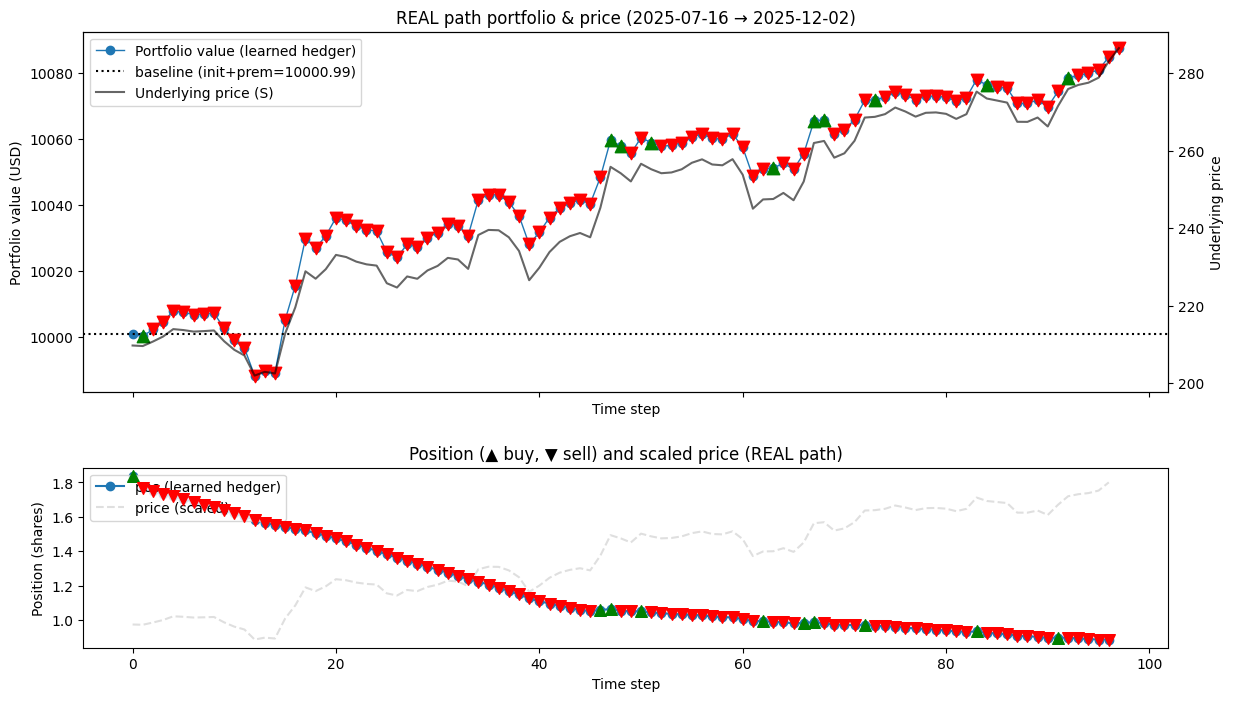

In [ ]:
if "options_df" in globals():
        real_results = real_options_scenario_report(
            results,
            options_df,
            t0_str="2025-07-16",      # your real options quote date
            end_date_str=None,
            initial_cash=10000.0,
            min_volume=10         # volume filter, tweak if needed
        )
else:
    print("options_df not found in globals(); skipping REAL options scenario.")


=== Tail risk diagnostics setup ===
Total premium received (portfolio) = 5.5360
Baseline used for PnLs = initial_cash + total_premium = 10005.5360

=== Tail risk diagnostics (P&L vs baseline, alpha=0.95) ===
              mean_PnL    std_PnL  VaR_PnL_95  CVaR_PnL_95
naked_short -57.933662  25.458994 -100.476608  -114.346718
hedged_phiZ -52.864948   7.511864  -65.824219   -72.038422
phi0_only   -57.981251  25.586420 -100.750977  -114.649315
bs_delta    -53.484901   6.045614  -63.150391   -72.204391

--- Comparison: hedged_phiZ vs naked_short (P&L units) ---
Naked:  VaR = -100.4766,  CVaR = -114.3467
Hedged: VaR = -65.8242, CVaR = -72.0384
✅ Hedger reduces tail losses: PnL in the worst α% scenarios is less negative.


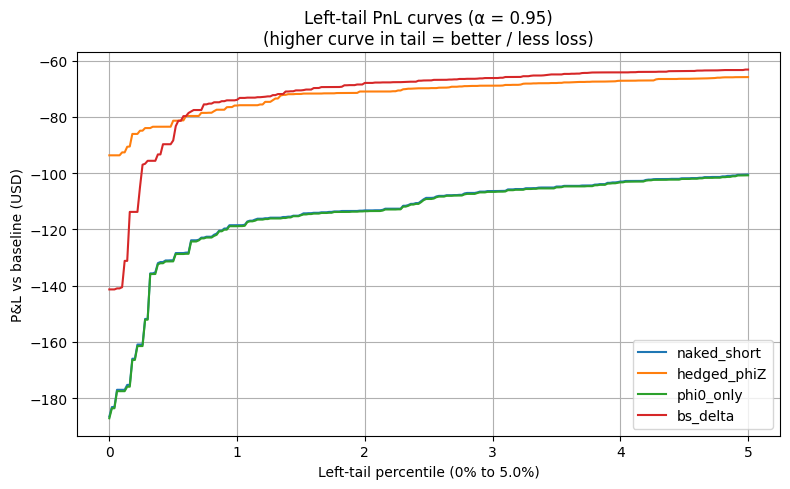

In [37]:
def tail_risk_diagnostics(results, money_results, alpha=0.95):
    """
    Compare tail risk of:
      - naked short portfolio (no hedging, only premium vs payoff)
      - learned phi(Z) hedger (sim_Z)
      - learned phi(0) hedger (sim_zero)
      - BS delta hedge (sim_bs)

    Uses terminal PnLs from monetary_test_report (already relative to
    baseline = initial_cash + total_premium) and constructs naked PnL
    vs the *same baseline*.

    Baseline convention:
      - All hedged strategies: PnL = terminal_value - (initial_cash + total_premium)
      - Naked: start with same baseline, pay total portfolio payoff Z,
        so final wealth = baseline - Z, hence PnL_vs_baseline = -Z.

    alpha: e.g. 0.95 -> look at worst 5% of PnL distribution.
    """

    # 1) Pull what we need
    Z_test = np.asarray(results['Z_test'], dtype=np.float32)
    premium_total = float(money_results.get('premium_total', 0.0))
    baseline = float(money_results.get('baseline', 0.0))

    print("\n=== Tail risk diagnostics setup ===")
    print(f"Total premium received (portfolio) = {premium_total:.4f}")
    print(f"Baseline used for PnLs = initial_cash + total_premium = {baseline:.4f}")

    # Naked short PnL relative to the SAME baseline (initial_cash + total_premium):
    # Start with baseline, do not hedge, only pay Z:
    #   final_wealth = baseline - Z
    #   => PnL_vs_baseline = final_wealth - baseline = -Z
    naked_pnls = -Z_test

    sim_Z    = money_results['sim_Z']
    sim_zero = money_results['sim_zero']
    sim_bs   = money_results['sim_bs']

    hedged_pnls = np.asarray(sim_Z['terminal_pnls'], dtype=np.float32)
    phi0_pnls   = np.asarray(sim_zero['terminal_pnls'], dtype=np.float32)
    bs_pnls     = np.asarray(sim_bs['terminal_pnls'], dtype=np.float32)

    # 2) Tail stats helper (works in PnL space: more negative = worse)
    def tail_stats(pnls, alpha):
        pnls = np.sort(np.asarray(pnls))   # ascending: worst first
        N = pnls.shape[0]
        tail_frac = 1.0 - alpha
        tail_count = max(int(np.floor(tail_frac * N)), 1)
        tail_slice = pnls[:tail_count]
        var_pnl = pnls[tail_count - 1]         # PnL at tail boundary (VaR in PnL units)
        cvar_pnl = float(tail_slice.mean())    # mean PnL in worst tail
        return var_pnl, cvar_pnl

    # 3) Compute stats for all strategies
    all_pnls = {
        "naked_short": naked_pnls,
        "hedged_phiZ": hedged_pnls,
        "phi0_only":   phi0_pnls,
        "bs_delta":    bs_pnls,
    }

    rows = {}
    for name, arr in all_pnls.items():
        arr = np.asarray(arr, dtype=np.float32)
        var_pnl, cvar_pnl = tail_stats(arr, alpha)
        rows[name] = {
            "mean_PnL": float(arr.mean()),
            "std_PnL": float(arr.std(ddof=1)),
            f"VaR_PnL_{int(alpha*100)}": float(var_pnl),
            f"CVaR_PnL_{int(alpha*100)}": float(cvar_pnl),
        }

    df = pd.DataFrame(rows).T

    print(f"\n=== Tail risk diagnostics (P&L vs baseline, alpha={alpha}) ===")
    print(df)

    # Quick textual verdict comparing naked vs hedged_phiZ
    var_naked   = df.loc["naked_short", f"VaR_PnL_{int(alpha*100)}"]
    cvar_naked  = df.loc["naked_short", f"CVaR_PnL_{int(alpha*100)}"]
    var_hedged  = df.loc["hedged_phiZ", f"VaR_PnL_{int(alpha*100)}"]
    cvar_hedged = df.loc["hedged_phiZ", f"CVaR_PnL_{int(alpha*100)}"]

    print("\n--- Comparison: hedged_phiZ vs naked_short (P&L units) ---")
    print(f"Naked:  VaR = {var_naked:.4f},  CVaR = {cvar_naked:.4f}")
    print(f"Hedged: VaR = {var_hedged:.4f}, CVaR = {cvar_hedged:.4f}")

    if var_hedged > var_naked and cvar_hedged > cvar_naked:
        print("✅ Hedger reduces tail losses: PnL in the worst α% scenarios is less negative.")
    else:
        print("⚠️ Hedger does not clearly dominate naked short in the left tail (or only partially).")

    # 4) Plot: left-tail PnL curves (sorted PnL vs tail percentile)
    plt.figure(figsize=(8,5))
    for name, arr in all_pnls.items():
        arr = np.sort(np.asarray(arr))
        N = len(arr)
        probs = np.linspace(0.0, 1.0, N, endpoint=False)  # 0 .. ~1
        tail_mask = probs <= (1.0 - alpha)                # e.g. 0–5%
        plt.plot(
            probs[tail_mask] * 100.0,    # percentile in %
            arr[tail_mask],              # PnL values
            label=name
        )
    plt.xlabel(f"Left-tail percentile (0% to {(1.0 - alpha)*100:.1f}%)")
    plt.ylabel("P&L vs baseline (USD)")
    plt.title(f"Left-tail PnL curves (α = {alpha})\n(higher curve in tail = better / less loss)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


tail_df = tail_risk_diagnostics(results, money_results, alpha=0.95)

In [45]:
def tail_risk_diagnostics(results, money_results, alpha=0.95):
    """
    Tail-risk comparison for a short options portfolio:

      • naked short portfolio (no hedging)
      • learned phi(Z) hedger (sim_Z)
      • learned phi(0) hedger (sim_zero)
      • BS delta hedge (sim_bs)

    All PnLs are measured RELATIVE to the SAME baseline:
      baseline = initial_cash + total_premium

    So:
      hedged_PnL  = terminal_value - baseline
      naked_PnL   = -Z_test  (final wealth = baseline - Z)
    """

    # -----------------------------
    # 1) Collect required objects
    # -----------------------------
    Z_test = np.asarray(results["Z_test"], dtype=np.float32)
    premium_total = float(money_results["premium_total"])
    baseline = float(money_results["baseline"])

    print("\n=== Tail Risk Diagnostics Setup ===")
    print(f"Total premium received = {premium_total:.4f}")
    print(f"Baseline for ALL PnLs = {baseline:.4f}\n")

    # Naked PnL relative to baseline: final wealth = baseline - Z
    # → PnL_vs_baseline = -Z
    naked_pnls = -Z_test

    sim_Z    = money_results["sim_Z"]       # hedger for phi(Z)
    sim_zero = money_results["sim_zero"]    # hedger for phi(0)
    sim_bs   = money_results["sim_bs"]      # Black–Scholes delta

    hedged_pnls = np.asarray(sim_Z["terminal_pnls"], dtype=np.float32)
    phi0_pnls   = np.asarray(sim_zero["terminal_pnls"], dtype=np.float32)
    bs_pnls     = np.asarray(sim_bs["terminal_pnls"], dtype=np.float32)

    # -----------------------------
    # 2) Left-tail statistics
    # -----------------------------
    def tail_stats(pnls, alpha):
        """
        For PnL values (MORE NEGATIVE = WORSE):
        Return:
            VaR_pnl  (the PnL threshold at alpha)
            CVaR_pnl (mean of worst tail)
        """
        pnls = np.sort(np.asarray(pnls))  # ascending → left tail first
        N = pnls.size
        tail_count = max(int((1 - alpha) * N), 1)
        tail_slice = pnls[:tail_count]
        var_pnl = pnls[tail_count - 1]
        cvar_pnl = tail_slice.mean()
        return var_pnl, cvar_pnl

    all_pnls = {
        "naked_short": naked_pnls,
        "hedged_phiZ": hedged_pnls,
        "phi0_only":   phi0_pnls,
        "bs_delta":    bs_pnls,
    }

    rows = {}
    for name, arr in all_pnls.items():
        arr = np.asarray(arr, dtype=np.float32)
        var_pnl, cvar_pnl = tail_stats(arr, alpha)
        rows[name] = {
            "mean_PnL": float(arr.mean()),
            "std_PnL": float(arr.std(ddof=1)),
            f"VaR_PnL_{int(alpha*100)}": float(var_pnl),
            f"CVaR_PnL_{int(alpha*100)}": float(cvar_pnl),
        }

    df = pd.DataFrame(rows).T

    print(f"=== Tail Risk Diagnostics (P&L vs baseline, alpha={alpha}) ===")
    print(df)

    # -----------------------------
    # 3) Tail-risk verdict
    # -----------------------------
    VaR_naked   = df.loc["naked_short", f"VaR_PnL_{int(alpha*100)}"]
    CVaR_naked  = df.loc["naked_short", f"CVaR_PnL_{int(alpha*100)}"]
    VaR_hedged  = df.loc["hedged_phiZ", f"VaR_PnL_{int(alpha*100)}"]
    CVaR_hedged = df.loc["hedged_phiZ", f"CVaR_PnL_{int(alpha*100)}"]

    print("\n--- Hedged vs Naked Tail Losses ---")
    print(f"Naked:  VaR={VaR_naked:.2f},  CVaR={CVaR_naked:.2f}")
    print(f"Hedged: VaR={VaR_hedged:.2f}, CVaR={CVaR_hedged:.2f}")

    if (VaR_hedged > VaR_naked) and (CVaR_hedged > CVaR_naked):
        print("✅ Hedged strategy REDUCES fat-tail losses.")
    else:
        print("⚠️ Hedger does NOT dominate naked short in the α-tail.")

    # -----------------------------
    # 4) Plot left-tail PnL curves
    # -----------------------------
    plt.figure(figsize=(8,5))
    for name, arr in all_pnls.items():
        arr = np.sort(np.asarray(arr))
        N = len(arr)
        probs = np.linspace(0, 1, N, endpoint=False)
        tail_mask = probs <= (1 - alpha)
        plt.plot(probs[tail_mask]*100, arr[tail_mask], label=name)

    plt.xlabel(f"Left-tail percentile (0–{(1-alpha)*100:.0f}%)")
    plt.ylabel("P&L vs baseline (USD)")
    plt.title(f"Tail PnL Curves (alpha={alpha})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df



=== Tail Risk Diagnostics Setup ===
Total premium received = 12.7300
Baseline for ALL PnLs = 10012.7300

=== Tail Risk Diagnostics (P&L vs baseline, alpha=0.95) ===
              mean_PnL    std_PnL  VaR_PnL_95  CVaR_PnL_95
naked_short -67.671562  48.725666 -150.135620  -174.371964
hedged_phiZ -56.429588  12.379519  -74.753906   -93.524155
phi0_only   -67.661240  48.675751 -150.043945  -174.255585
bs_delta    -56.538200  11.722120  -78.166016   -94.338028

--- Hedged vs Naked Tail Losses ---
Naked:  VaR=-150.14,  CVaR=-174.37
Hedged: VaR=-74.75, CVaR=-93.52
✅ Hedged strategy REDUCES fat-tail losses.


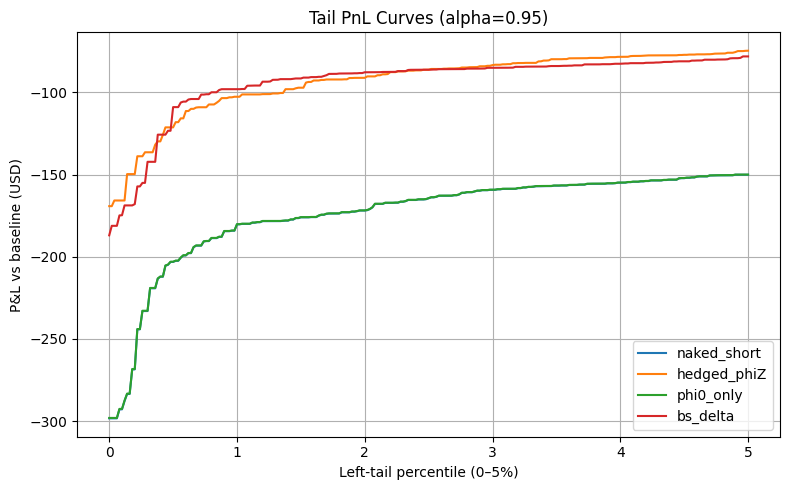

In [46]:
tail_df = tail_risk_diagnostics(results, money_results, alpha=0.95)

In [77]:
def tail_risk_diagnostics(results, money_results, alpha=0.95):
    """
    Tail-risk comparison for a short options portfolio:

      • naked short portfolio (no hedging)
      • learned phi(Z) hedger (sim_Z)
      • learned phi(0) hedger (sim_zero)
      • BS delta hedge (sim_bs)

    All PnLs are measured RELATIVE to the SAME baseline:
      baseline = initial_cash + total_premium

    So:
      hedged_PnL  = terminal_value - baseline
      naked_PnL   = -Z_test  (final wealth = baseline - Z)
    """

    # -----------------------------
    # 1) Collect required objects
    # -----------------------------
    Z_test = np.asarray(results["Z_test"], dtype=np.float32)
    premium_total = float(money_results["premium_total"])
    baseline = float(money_results["baseline"])

    print("\n=== Tail Risk Diagnostics Setup ===")
    print(f"Total premium received = {premium_total:.4f}")
    print(f"Baseline for ALL PnLs = {baseline:.4f}\n")

    # Naked PnL relative to baseline: final wealth = baseline - Z
    # → PnL_vs_baseline = -Z
    naked_pnls = -Z_test

    sim_Z    = money_results["sim_Z"]       # hedger for phi(Z)
    sim_zero = money_results["sim_zero"]    # hedger for phi(0)
    sim_bs   = money_results["sim_bs"]      # Black–Scholes delta

    hedged_pnls = np.asarray(sim_Z["terminal_pnls"], dtype=np.float32)
    phi0_pnls   = np.asarray(sim_zero["terminal_pnls"], dtype=np.float32)
    bs_pnls     = np.asarray(sim_bs["terminal_pnls"], dtype=np.float32)

    # -----------------------------
    # 2) Left-tail statistics
    # -----------------------------
    def tail_stats(pnls, alpha):
        """
        For PnL values (MORE NEGATIVE = WORSE):
        Return:
            VaR_pnl  (the PnL threshold at alpha)
            CVaR_pnl (mean of worst tail)
        """
        pnls = np.sort(np.asarray(pnls))  # ascending → left tail first
        N = pnls.size
        tail_count = max(int((1 - alpha) * N), 1)
        tail_slice = pnls[:tail_count]
        var_pnl = pnls[tail_count - 1]
        cvar_pnl = tail_slice.mean()
        return var_pnl, cvar_pnl

    all_pnls = {
        "naked_short": naked_pnls,
        "hedged_phiZ": hedged_pnls,
        "phi0_only":   phi0_pnls,
        "bs_delta":    bs_pnls,
    }

    rows = {}
    for name, arr in all_pnls.items():
        arr = np.asarray(arr, dtype=np.float32)
        var_pnl, cvar_pnl = tail_stats(arr, alpha)
        rows[name] = {
            "mean_PnL": float(arr.mean()),
            "std_PnL": float(arr.std(ddof=1)),
            f"VaR_PnL_{int(alpha*100)}": float(var_pnl),
            f"CVaR_PnL_{int(alpha*100)}": float(cvar_pnl),
        }

    df = pd.DataFrame(rows).T

    print(f"=== Tail Risk Diagnostics (P&L vs baseline, alpha={alpha}) ===")
    print(df)

    # -----------------------------
    # 3) Tail-risk verdict
    # -----------------------------
    VaR_naked   = df.loc["naked_short", f"VaR_PnL_{int(alpha*100)}"]
    CVaR_naked  = df.loc["naked_short", f"CVaR_PnL_{int(alpha*100)}"]
    VaR_hedged  = df.loc["hedged_phiZ", f"VaR_PnL_{int(alpha*100)}"]
    CVaR_hedged = df.loc["hedged_phiZ", f"CVaR_PnL_{int(alpha*100)}"]

    print("\n--- Hedged vs Naked Tail Losses ---")
    print(f"Naked:  VaR={VaR_naked:.2f},  CVaR={CVaR_naked:.2f}")
    print(f"Hedged: VaR={VaR_hedged:.2f}, CVaR={CVaR_hedged:.2f}")

    if (VaR_hedged > VaR_naked) and (CVaR_hedged > CVaR_naked):
        print("✅ Hedged strategy REDUCES fat-tail losses.")
    else:
        print("⚠️ Hedger does NOT dominate naked short in the α-tail.")

    # -----------------------------
    # 4) Plot left-tail PnL curves
    # -----------------------------
    plt.figure(figsize=(8,5))
    for name, arr in all_pnls.items():
        arr = np.sort(np.asarray(arr))
        N = len(arr)
        probs = np.linspace(0, 1, N, endpoint=False)
        tail_mask = probs <= (1 - alpha)
        plt.plot(probs[tail_mask]*100, arr[tail_mask], label=name)

    plt.xlabel(f"Left-tail percentile (0–{(1-alpha)*100:.0f}%)")
    plt.ylabel("P&L vs baseline (USD)")
    plt.title(f"Tail PnL Curves (alpha={alpha})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


=== Tail Risk Diagnostics Setup ===
Total premium received = 12.7300
Baseline for ALL PnLs = 10012.7300

=== Tail Risk Diagnostics (P&L vs baseline, alpha=0.95) ===
              mean_PnL    std_PnL  VaR_PnL_95  CVaR_PnL_95
naked_short -67.671562  48.725666 -150.135620  -174.371964
hedged_phiZ -61.237186  12.380244  -80.095703   -98.096062
phi0_only   -67.668709  48.652336 -150.014648  -174.219193
bs_delta    -63.836239  13.071059  -88.890625  -105.730179

--- Hedged vs Naked Tail Losses ---
Naked:  VaR=-150.14,  CVaR=-174.37
Hedged: VaR=-80.10, CVaR=-98.10
✅ Hedged strategy REDUCES fat-tail losses.


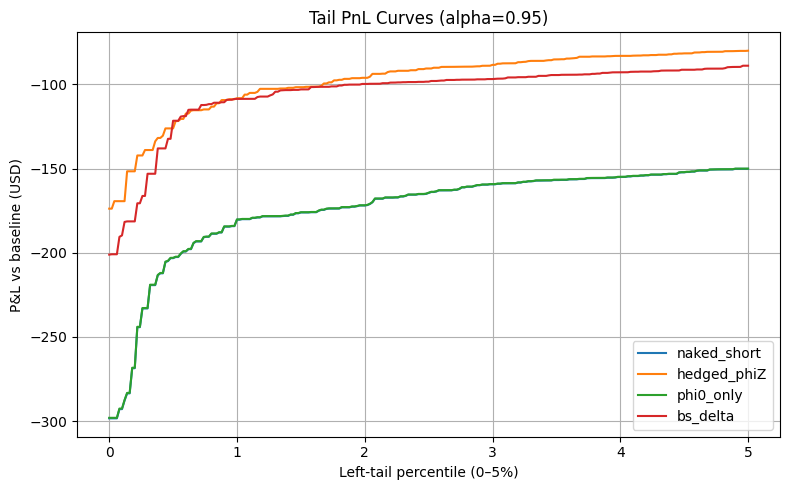

In [78]:
tail_df = tail_risk_diagnostics(results, money_results, alpha=0.95)